**3.1 Data Preprocessing and Transformation**

This section includes the data preparations required for the experiment, such as anonymization, handling missing information, and combining multiple sources into a single DataFrame.

The data for this study comes from two different sources (**bp_questionnaire.csv** and **nps.csv**). This section will cover the data preprocessing and transformation steps for each source.


**Objectives:**

*   Applying preprocessing and transformation techniques to prepare the dataset.

**3.1.1 Best Practices Survey Dataset Preparation.**

In the following code snippet, the **bp_questionnaire.csv** file is loaded and imported into a pandas DataFrame:


In [1]:
# Import file that contains the best practices list
import pandas as pd

# Mount Google Drive to this environment
from google.colab import drive
drive.mount('/content/gdrive')
tcc_folder = 'gdrive/My Drive/[Pós] AI and Big Data-USP/TCC/'

# Load the csv file which contains the questionnaire answers for each project.
bp_questionnaire = pd.read_csv(tcc_folder + 'data/bp_questionnaire.csv')

# Create the DataFrame from the CSV file.
bp_questionnaire_df = pd.DataFrame(bp_questionnaire)

# Convert the dates to date format
bp_questionnaire_df['date'] = pd.to_datetime(bp_questionnaire_df['date'], infer_datetime_format=True)
bp_questionnaire_df

Mounted at /content/gdrive


<ipython-input-1-71478397e325>:16: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  bp_questionnaire_df['date'] = pd.to_datetime(bp_questionnaire_df['date'], infer_datetime_format=True)


The best practice statements in this questionnaire comprise private information. Therefore, in the following code snippet, the practice statements are replaced by generic identifiers: practice1, practice2, ..., practiceN.

In [2]:
# Anonymize the practices and replace it by a generic name
practices, uniques =  pd.factorize(bp_questionnaire_df['practice'])
practices = ['practice'+str(l+1) for l in practices]
bp_questionnaire_df['practice'] = practices
bp_questionnaire_df

The data source also contains some duplicated information because some teams may have responded multiple times within the same month.

To keep the data consistent, only one response per month should be considered. In the following code, a new column that includes just the year and month is created. Subsequently, the DataFrame is ordered by date so that, after deleting duplicates, only the last evaluation for each month is kept.

In [3]:
# This code snippet will remove the duplicated entries for the best practices survey

# We need to make sure that there is only 1 entry for each month.
# If there there are duplicated entries, we will consider the latest one.

import datetime;

# Create a new date object considering only year and month information.
def convert_date(row):
    year = row['date'].year
    month = row['date'].month
    return datetime.date(year, month, 1)

# Create a new column with the new date (first day of the month)
bp_questionnaire_df['year_month'] = bp_questionnaire_df.apply(lambda row: convert_date(row), axis=1)

# Sort values in a way that the last evaluation for each month are listed first.
bp_questionnaire_df = bp_questionnaire_df.sort_values(by=['date', 'project'], ascending=[False, True])
bp_questionnaire_df = bp_questionnaire_df.reset_index()
del bp_questionnaire_df['index']

# Print the current size of the dataframe
print("Before deletion: " + str(bp_questionnaire_df.size))

# Remove duplicates
bp_questionnaire_df = bp_questionnaire_df.drop_duplicates(subset=['project', 'year_month', 'practice']);

# Print the current size of the dataframe
print("After deletion: " + str(bp_questionnaire_df.size))

# Order and reset index
bp_questionnaire_df = bp_questionnaire_df.sort_values(by=['date', 'project'], ascending=[True, True])
bp_questionnaire_df = bp_questionnaire_df.reset_index()
del bp_questionnaire_df['index']

del bp_questionnaire_df['date']
bp_questionnaire_df = bp_questionnaire_df.rename(columns={'year_month': 'date'})

bp_questionnaire_df = bp_questionnaire_df[['project', 'date','practice', 'evaluation']]
bp_questionnaire_df

Before deletion: 291635
After deletion: 245290


As the next step, it is necessary to pivot the table so that the answers indicating whether the teams follow a certain practice become columns.

This is a preparation step for the dataset to ensure it has the ideal format for working with time series problems.

In [4]:
# This library will help us to have a natural human-friendly sorting for the practices names.
from natsort import natsorted

# Pivot table: Now it is necessary to pivot table so we can transform the rows into columns of best practices.
bp_pivot = bp_questionnaire_df.pivot_table(index=['project', 'date'], columns='practice', values='evaluation', aggfunc='max').reset_index()

# Sort the practices in a human-friendly way.
sorted_list = natsorted(bp_pivot.columns.to_list())
sorted_list.insert(0, 'project')
sorted_list.pop()

bp_pivot = bp_pivot[sorted_list]

# Sort the pivoted table
bp_pivot = bp_pivot.sort_values(by=['date', 'project'])

# Reset index.
bp_pivot = bp_pivot.reset_index()
del bp_pivot['index']
bp_pivot

The dataset is now compatible with the expected shape for time series problems. However, there are still some NaN values because not all teams answered all the questions.

In this study, all unanswered survey questions will be considered as 'No' (binary, 0).

In [5]:
# Check the total number of null items
bp_pivot.isnull().sum()

#There are some NaN that should be filled with "0"
bp_pivot = bp_pivot.fillna(0)

#Output as a file.
bp_pivot.to_csv(tcc_folder + 'data/bp_questionnaire_digested.csv', index=False)

**3.1.2 Net Promoter Score (NPS) Survey Dataset Preparation.**

The second step is to prepare the dataset that contains the Net Promoter Score (NPS) information.

In the following code snippet, the **nps.csv** file is loaded and imported into a pandas DataFrame:


In [6]:
# Load the csv file which contains the nps answers for each project.
nps = pd.read_csv(tcc_folder + 'data/nps.csv')

#Create the DataFrame from the CSV file.
nps_df = pd.DataFrame(nps)

#Convert the dates to date format
nps_df['date'] = pd.to_datetime(nps_df['date'], infer_datetime_format=True)

<ipython-input-6-a820bb1aeaec>:8: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  nps_df['date'] = pd.to_datetime(nps_df['date'], infer_datetime_format=True)


The data source may also contain some duplicated information because some teams may have responded to the NPS survey multiple times within the same month.

In this study, to keep the data consistent, only one response per month will be considered as the time series frequency. Therefore, in the next code snippet, a new column is created that includes only the year and month. After that, the DataFrame.drop_duplicates method is used to ensure that only one entry exists for each month.

In [7]:
# Create a new date object considering only year and month information.
def convert_date(row):
    year = row['date'].year
    month = row['date'].month
    return datetime.date(year, month, 1)

# Create a new column with the new date (first day of the month).
nps_df['year_month'] = nps_df.apply(lambda row: convert_date(row), axis=1)

# Sort values in a way that the last evaluation for each month are listed first.
nps_df = nps_df.sort_values(by=['date'], ascending=[False])
# Reset index.
nps_df = nps_df.reset_index()
del nps_df['index']

# Print the current size of the dataframe.
print("Before deletion: " + str(nps_df.size))

# Remove duplicates based on the new column.
nps_df = nps_df.drop_duplicates(subset=['project', 'year_month']);

# Print the current size of the dataframe.
print("After deletion: " + str(nps_df.size))

# Sort the NPS responses by date (descending).
nps_df = nps_df.sort_values(by=['date', 'project'], ascending=[True, True])
# Reset index.
nps_df = nps_df.reset_index()
del nps_df['index']

del nps_df['date']
nps_df = nps_df.rename(columns={'year_month': 'date'})

nps_df = nps_df[['project', 'date','nps']]
nps_df

Before deletion: 780
After deletion: 780


Now it is necessary to consider the start date and end date of the time series to be used in this study.

Although the Net Promoter Score survey has been conducted since early 2020, the Best Practices Survey only started in mid-2021. Based on that, this study will only consider NPS data from mid-2021 onwards.
In the following code, the NPS measurements prior to June 2021 are deleted.

Additionally, some projects started and ended in a very short period, having only a few entries in the survey. In this study, the data for these short-term projects will not be considered and are removed from the DataFrame.

In [9]:
# Delete nps measurements from period before start applying the Best practices questionnaire
drop_index = nps_df[nps_df.date < datetime.date(2021, 6, 1)].index
nps_df.drop(drop_index, inplace=True)

# Drop project which is not in the Best practices evaluation sheet
nps_df.drop(nps_df[nps_df.project == 'E***'].index, inplace=True)

# Just select the Project if number of measurements are bigger than 5)
nps_count = nps_df.groupby(['project']).count()

# Filter the projets that have at least 6 measurements.
filtered_nps = nps_count.loc[nps_count['nps'] > 5].reset_index()

# Assign the valid projects in a list.
projects_in_file = filtered_nps.project.tolist()
projects_list = sorted(list(set(projects_in_file)))

# Filter the DataFrame.
nps_df = nps_df[nps_df.project.isin(projects_list)]

# Print the DataFrame.
nps_df

When plotting the NPS time series on a chart, it is possible to visualize how it changes over time. It is also apparent that some time series are incomplete:





In [10]:
#import libraries for data plotting
import plotly.graph_objects as go
#import random for random color generation
import random

fig = go.Figure()

#get projects list
projects_in_file = nps_df.project.tolist()
projects_list = sorted(list(set(projects_in_file)))

for project in projects_list:
  project_evaluations = nps_df[nps_df.project == project]
  color = "%06x" % random.randint(0, 0xFFFFFF)
  fig.add_trace(go.Scatter(x=project_evaluations.date, y=project_evaluations.nps, name = project, line = dict(color = '#' + color), opacity = 0.8))

fig.show()

Additionally, from the previous chart, it is noted that the NPS measurements occur every 3 months, in contrast with the Best Practices Survey, which is conducted at least once per month.

It is necessary to adjust the time series to ensure the same frequency between both data sources.

The solution applied in this study was to generate a constant time series for all the projects with a monthly frequency. The NPS data is then merged with this DataFrame so the missing NPS measurements will become null.

As the next step, the DataFrame.interpolate method is applied to generate a linear line between the available NPS measurements.

This method is applied to each project key in the dataset.

In [11]:
# Generate a data range from 2021/06 to 2024/06.
data_range = pd.date_range(start='2021-06-01', end='2024-06-01', freq='MS')

time_series = []

# For each project key, apply the data range in a list.
for project in projects_list:
  for date in data_range:
    time_series.append([project, date])

# Create a DataFrame from the list.
time_series_df = pd.DataFrame(time_series, columns=['project', 'date'])
# Convert it to use the same data format as the other data sources.
time_series_df['date'] = time_series_df.apply(lambda row: convert_date(row), axis=1)

# Join the tables, missing dates in the original table will be filled with NaN.
nps_digest_df = time_series_df.merge(nps_df, left_on=['project','date'], right_on=['project','date'], how='left')
nps_digest_df.set_index(['project', 'date'])

for project in projects_list:
  project_evaluations = nps_digest_df[nps_digest_df.project == project]
  # Fill NaN with the interpolate method. After that, fill the missing back and forth missing information with the first or previous available.
  project_evaluations['nps'] = project_evaluations['nps'].interpolate().bfill().ffill()
  nps_digest_df[nps_digest_df.project == project] = project_evaluations

# Print the DataFrame
nps_digest_df

#Output as a file.
nps_digest_df.to_csv(tcc_folder + 'data/nps_digested.csv', index=False)

<ipython-input-11-ca593804aea1>:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



By plotting the NPS time series on a chart again, it is possible to visualize how it changes over time. The incomplete time series are no longer present:

In [12]:
#import libraries for data plotting
import plotly.graph_objects as go
#import random for random color generation
import random

fig = go.Figure()

#get projects list
projects_in_file = nps_digest_df.project.tolist()
projects_list = sorted(list(set(projects_in_file)))

for project in projects_list:
  project_evaluations = nps_digest_df[nps_digest_df.project == project]
  color = "%06x" % random.randint(0, 0xFFFFFF)
  fig.add_trace(go.Scatter(x=project_evaluations.date, y=project_evaluations.nps, name = project, line = dict(color = '#' + color), opacity = 0.8))

fig.show()

**3.1.3 Dataset Combination.**

The third step is to combine both the Best Practices and NPS surveys into a single DataFrame.

The Best Practices Survey still contains some measurements for projects that are not in the NPS file. In the following code, select the DataFrame rows based on the filtered project list:


In [13]:
# Load digested files.
bp_questionnaire_digested = pd.read_csv(tcc_folder + 'data/bp_questionnaire_digested.csv')
# Create the DataFrame from the CSV file.
bp_questionnaire_digested_df = pd.DataFrame(bp_questionnaire_digested)
bp_questionnaire_digested_df['date'] = pd.to_datetime(bp_questionnaire_digested_df['date'], infer_datetime_format=True)

nps_digested = pd.read_csv(tcc_folder + 'data/nps_digested.csv')
# Create the DataFrame from the CSV file.
nps_digested_df = pd.DataFrame(nps_digested)
nps_digested_df['date'] = pd.to_datetime(nps_digested_df['date'], infer_datetime_format=True)


# Delete the rows from the best practices list that contains projects that doesn't belong to the target list.
bp_questionnaire_digested_df = bp_questionnaire_digested_df[bp_questionnaire_digested_df['project'].isin(projects_list)]

<ipython-input-13-df0436b98879>:5: UserWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.

<ipython-input-13-df0436b98879>:10: UserWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.



The combined dataset is obtained merging the NPS and Best Practices digested datasets. Even after this operation, there will still be some project evaluations missing for some months in the time series. The missing data was filled using the bfill and ffill methods.

In the next steps, the columns that contain only "0" are deleted, as they are not useful as features for training purposes.

In [14]:
# Join the tables, missing dates in the original table will be filled with NaN
tcc_data_df = pd.merge(
  nps_digested_df, bp_questionnaire_digested_df, how="outer", on=["project", "date"]
)

tcc_data_df.set_index(['project', 'date'])

for project in projects_list:
  project_evaluations = tcc_data_df[tcc_data_df.project == project]
  # Fill NaN
  project_evaluations = project_evaluations.bfill().ffill()
  tcc_data_df[tcc_data_df.project == project] = project_evaluations

tcc_data_df['nps'] = tcc_data_df['nps'].astype(int)

# Delete zero only columns
tcc_data_df = tcc_data_df.loc[:, (tcc_data_df != 0).any(axis=0)]

# Print the DataFrame
tcc_data_df

The project names are considered sensitive information and need to be anonymized. The anonymization process followed the same approach used for the practices. The real project names are replaced by identifiers following the pattern Project1, Project2, ..., ProjectN.

In [15]:
# Anonymize the project and replace it by a generic name
projects, uniques =  pd.factorize(tcc_data_df['project'])
projects = ['Project'+str(l+1) for l in projects]
tcc_data_df['project'] = projects
tcc_data_df

project       date  nps  practice1  practice2  practice3  practice4  \
0     Project1 2021-06-01   25        0.0        1.0        0.0        0.0   
1     Project1 2021-07-01   25        0.0        1.0        0.0        0.0   
2     Project1 2021-08-01   25        0.0        1.0        0.0        0.0   
3     Project1 2021-09-01   25        0.0        1.0        0.0        0.0   
4     Project1 2021-10-01   25        0.0        1.0        0.0        0.0   
..         ...        ...  ...        ...        ...        ...        ...   
365  Project10 2024-02-01   50        1.0        1.0        1.0        0.0   
366  Project10 2024-03-01   50        1.0        1.0        1.0        0.0   
367  Project10 2024-04-01   39        1.0        1.0        1.0        0.0   
368  Project10 2024-05-01   28        1.0        1.0        1.0        0.0   
369  Project10 2024-06-01   17        1.0        1.0        1.0        0.0   

     practice5  practice6  practice7  ...  practice278  practice279  \
0          0.0        0.0        1.0  ...          0.0          0.0   
1          0.0        0.0        1.0  ...          0.0          0.0   
2          0.0        0.0        1.0  ...          0.0          0.0   
3          0.0        0.0        1.0  ...          0.0          0.0   
4          0.0        0.0        1.0  ...          0.0          0.0   
..         ...        ...        ...  ...          ...          ...   
365        1.0        0.0        1.0  ...          1.0          0.0   
366        1.0        0.0        1.0  ...          1.0          0.0   
367        1.0        0.0        1.0  ...          1.0          0.0   
368        1.0        0.0        1.0  ...          1.0          0.0   
369        1.0        0.0        1.0  ...          1.0          0.0   

     practice280  practice281  practice282  practice283  practice284  \
0            0.0          0.0          0.0          0.0          0.0   
1            0.0          0.0          0.0          0.0          0.0   
2            0.0          0.0          0.0          0.0          0.0   
3            0.0          0.0          0.0          0.0          0.0   
4            0.0          0.0          0.0          0.0          0.0   
..           ...          ...          ...          ...          ...   
365          1.0          1.0          1.0          1.0          0.0   
366          1.0          1.0          1.0          1.0          0.0   
367          1.0          1.0          1.0          1.0          0.0   
368          1.0          1.0          1.0          1.0          0.0   
369          1.0          1.0          1.0          1.0          0.0   

     practice285  practice286  practice287  
0            0.0          0.0          0.0  
1            0.0          0.0          0.0  
2            0.0          0.0          0.0  
3            0.0          0.0          0.0  
4            0.0          0.0          0.0  
..           ...          ...          ...  
365          0.0          0.0          0.0  
366          0.0          0.0          0.0  
367          0.0          0.0          0.0  
368          0.0          0.0          0.0  
369          0.0          0.0          0.0  

[370 rows x 213 columns]

The resulting dataset containing combined information from NPS and Best Practices Evaluation is saved in a csv file:

In [16]:
#Output as a file.
tcc_data_df.to_csv(tcc_folder + 'data/tcc-data.csv', index=False)

Check once again how the NPS time series looks. Make sure that the timeline is continuous and free of missing information:

In [17]:
#import libraries for data plotting
import plotly.graph_objects as go
#import random for random color generation
import random

fig = go.Figure()

#get projects list
projects_in_file = tcc_data_df.project.tolist()
projects_list = sorted(list(set(projects_in_file)))

for project in projects_list:
  project_evaluations = tcc_data_df[tcc_data_df.project == project]
  color = "%06x" % random.randint(0, 0xFFFFFF)
  fig.add_trace(go.Scatter(x=project_evaluations.date, y=project_evaluations.nps, name = project, line = dict(color = '#' + color), opacity = 0.8))

fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



**3.2. Exploratory Data Analysis (EDA)**

In the previous section, two different datasets were prepared, transformed, and combined into a single dataset. In this section, an exploratory data analysis will be conducted on the resulting dataset.


In [18]:
# Import libraries
import math
import statistics
import numpy as np
import scipy.stats
import pandas as pd

# Mount Google Drive to this environment
from google.colab import drive
drive.mount('/content/gdrive')
tcc_folder = 'gdrive/My Drive/[Pós] AI and Big Data-USP/TCC/'

# Load csv resulting data source
data = pd.read_csv(tcc_folder + 'data/tcc-data.csv')

evaluations = pd.DataFrame(data)
evaluations['date'] = pd.to_datetime(evaluations['date'], infer_datetime_format=True)

# Print data frame
evaluations

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


<ipython-input-18-5b50f8984d62>:17: UserWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.



project       date  nps  practice1  practice2  practice3  practice4  \
0     Project1 2021-06-01   25        0.0        1.0        0.0        0.0   
1     Project1 2021-07-01   25        0.0        1.0        0.0        0.0   
2     Project1 2021-08-01   25        0.0        1.0        0.0        0.0   
3     Project1 2021-09-01   25        0.0        1.0        0.0        0.0   
4     Project1 2021-10-01   25        0.0        1.0        0.0        0.0   
..         ...        ...  ...        ...        ...        ...        ...   
365  Project10 2024-02-01   50        1.0        1.0        1.0        0.0   
366  Project10 2024-03-01   50        1.0        1.0        1.0        0.0   
367  Project10 2024-04-01   39        1.0        1.0        1.0        0.0   
368  Project10 2024-05-01   28        1.0        1.0        1.0        0.0   
369  Project10 2024-06-01   17        1.0        1.0        1.0        0.0   

     practice5  practice6  practice7  ...  practice278  practice279  \
0          0.0        0.0        1.0  ...          0.0          0.0   
1          0.0        0.0        1.0  ...          0.0          0.0   
2          0.0        0.0        1.0  ...          0.0          0.0   
3          0.0        0.0        1.0  ...          0.0          0.0   
4          0.0        0.0        1.0  ...          0.0          0.0   
..         ...        ...        ...  ...          ...          ...   
365        1.0        0.0        1.0  ...          1.0          0.0   
366        1.0        0.0        1.0  ...          1.0          0.0   
367        1.0        0.0        1.0  ...          1.0          0.0   
368        1.0        0.0        1.0  ...          1.0          0.0   
369        1.0        0.0        1.0  ...          1.0          0.0   

     practice280  practice281  practice282  practice283  practice284  \
0            0.0          0.0          0.0          0.0          0.0   
1            0.0          0.0          0.0          0.0          0.0   
2            0.0          0.0          0.0          0.0          0.0   
3            0.0          0.0          0.0          0.0          0.0   
4            0.0          0.0          0.0          0.0          0.0   
..           ...          ...          ...          ...          ...   
365          1.0          1.0          1.0          1.0          0.0   
366          1.0          1.0          1.0          1.0          0.0   
367          1.0          1.0          1.0          1.0          0.0   
368          1.0          1.0          1.0          1.0          0.0   
369          1.0          1.0          1.0          1.0          0.0   

     practice285  practice286  practice287  
0            0.0          0.0          0.0  
1            0.0          0.0          0.0  
2            0.0          0.0          0.0  
3            0.0          0.0          0.0  
4            0.0          0.0          0.0  
..           ...          ...          ...  
365          0.0          0.0          0.0  
366          0.0          0.0          0.0  
367          0.0          0.0          0.0  
368          0.0          0.0          0.0  
369          0.0          0.0          0.0  

[370 rows x 213 columns]

**3.2.1 Net Promoter Score time series analysis**

Firstly, let's try to understand how the NPS envolves over time for each project.


In [19]:
#import libraries for data plotting
import plotly.graph_objects as go
#import random for random color generation
import random

fig = go.Figure()

#get projects list
projects_in_file = evaluations.project.tolist()
projects_list = sorted(list(set(projects_in_file)))

for project in projects_list:
  project_evaluations = evaluations[evaluations.project == project]
  color = "%06x" % random.randint(0, 0xFFFFFF)
  fig.add_trace(go.Scatter(x=project_evaluations.date, y=project_evaluations.nps, name = project, line = dict(color = '#' + color), opacity = 0.8))

fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



To analyze the distribution of NPS (Net Promoter Score) values effectively, one can create a histogram chart. This type of chart allows for a visual representation of how NPS scores are spread across different ranges, helping to identify patterns, trends, and any potential outliers in the data.

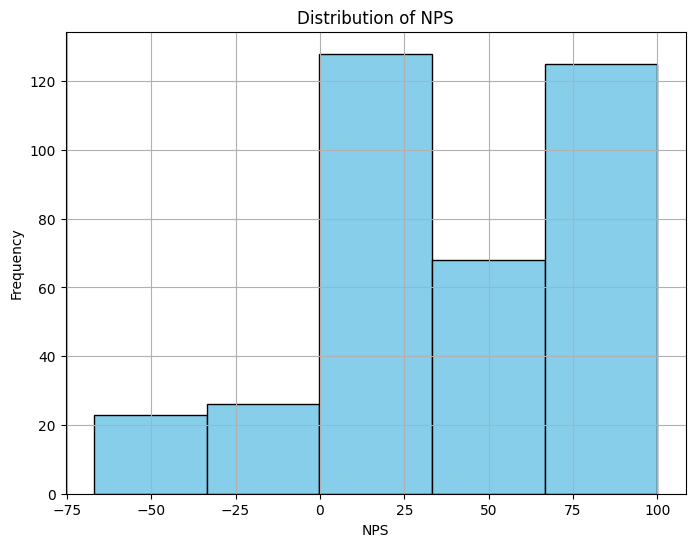

In [20]:
# Display a chart with the distribution of nps per project
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Plotting the distribution of NPS
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(8, 6))
plt.hist(evaluations['nps'], bins=5, color='skyblue', edgecolor='black')
plt.title('Distribution of NPS')
plt.xlabel('NPS')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Box plot charts can also be used to understand the distribution of NPS for each project by month. The results can be analyzed below:

Text(0.5, 0, 'Date')

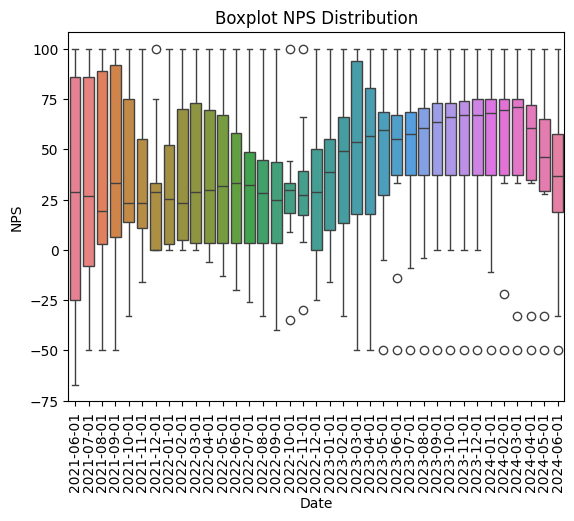

In [21]:
# Display a chart with the distribution of nps per project
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.title(f'Boxplot NPS Distribution');
plt.xticks(rotation=90)

sns.boxplot(x='date', y='nps', data=evaluations, hue='date', legend=False)
plt.ylabel('NPS')
plt.xlabel('Date')

By analyzing the boxplot chart above, it is possible to observe that the median shows an increasing trend until around March 2024, after which it starts to decline. Additionally, the 25th percentile is concentrated in November and December 2022. From May 2023 onwards, there is an outlier with a negative NPS value.

**3.2.2 Exogenous features analysis and selection**

The correlation between the features is calculated and plotted in a heatmap.

In the first column of the resulting chart, it is possible to understand the correlation between the Best Practices Survey items' responses and the NPS, which is the target information to be predicted in this study.

In [22]:
# Using Pearson Correlation
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(150,120))
cor = evaluations.corr(numeric_only=True)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Pearson Correlation is a statistical method that quantifies the relationship between two data sets by comparing their attributes and producing a score ranging from -1 to +1. By analysing the correlation heatmap matrix using Pearson correlation, it is possible to see that some best practices are highly correlated among eachother.

The most important information is the correlation between the target attribute to be predicted (NPS) and the other exogenous features (practices), which can be observed in the first column and in the first row of the matrix.

The dataset contains numerous features, and to enhance its relevance, it’s important to select those that contribute most effectively to the outcome. Correlation-based Feature Selection (CFS) is a technique designed to identify subsets of features that exhibit high correlation with the target variable while maintaining low inter-correlation among themselves. This approach aims to select a feature subset that offers the most valuable information about the target variable while reducing redundancy.

In [23]:
# Get correlation with the "nps" column
cor_target = abs(cor["nps"])

number_selected = 11
top = cor_target.sort_values(ascending=False)[:number_selected].index
top

Index(['nps', 'practice25', 'practice37', 'practice146', 'practice285',
       'practice81', 'practice38', 'practice265', 'practice71', 'practice7',
       'practice271'],
      dtype='object')

In [24]:
#Print DataFrame containing higher correlations:
top_df = cor_target.sort_values(ascending=False)
top_df.drop(['nps'], inplace=True)
#keep only top 10 itens in top_df
top_df = top_df[:number_selected]
top_df

practice25     0.573868
practice37     0.500470
practice146    0.454020
practice285    0.426436
practice81     0.402678
practice38     0.397752
practice265    0.393888
practice71     0.379267
practice7      0.375722
practice271    0.355200
practice156    0.354635
Name: nps, dtype: float64

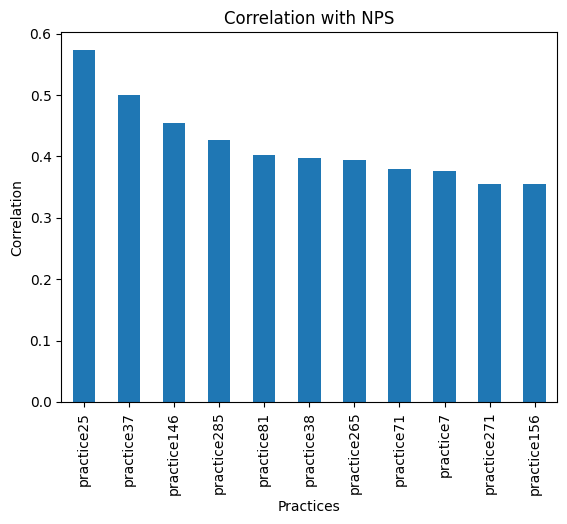

In [25]:
#Plot a bar chart with the values form this DataFrame where y axis are the practices
top_df.plot(kind='bar')
plt.title('Correlation with NPS')
plt.xlabel('Practices')
plt.ylabel('Correlation')
plt.show()

After that, the correlation among the select features is checked once again, and the results are visualized in a heatmap matrix.

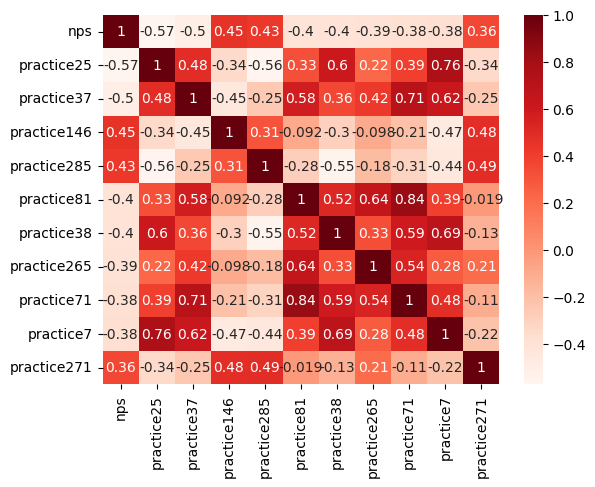

In [26]:
# Calculate correlation among the selected columns
relevant_features = evaluations[top]
target_corr_matrix = relevant_features.corr()

plt.figure()
sns.heatmap(target_corr_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

Finally, only the features with correlation lower than 0.6 are selected.

In [27]:
# Get upper triangle of correlation matrix
upper = target_corr_matrix.where(np.triu(np.ones(target_corr_matrix.shape), k=1).astype(bool))
# Find features with correlation greater than 0.6
to_drop = [column for column in upper.columns if any(upper[column] > 0.6)]

print(to_drop)

['practice38', 'practice265', 'practice71', 'practice7']


In [28]:
# Drop highly correlated features
target_corr_matrix.drop(to_drop, axis=1, inplace=True)

# Create a list of columns to keep, starting with essential columns
columns = ["project", "date"]
# Append the relevant features to the columns list
columns.extend(target_corr_matrix.columns.values)

# Filter the evaluations DataFrame to keep only the relevant columns
evaluations = evaluations[columns]

# Delete column with only zeros
evaluations = evaluations.loc[:, (evaluations != 0).any(axis=0)]

# Display the filtered DataFrame
evaluations

project       date  nps  practice25  practice37  practice146  \
0     Project1 2021-06-01   25         1.0         1.0          0.0   
1     Project1 2021-07-01   25         1.0         1.0          0.0   
2     Project1 2021-08-01   25         1.0         1.0          0.0   
3     Project1 2021-09-01   25         1.0         1.0          0.0   
4     Project1 2021-10-01   25         1.0         1.0          0.0   
..         ...        ...  ...         ...         ...          ...   
365  Project10 2024-02-01   50         1.0         1.0          1.0   
366  Project10 2024-03-01   50         1.0         1.0          1.0   
367  Project10 2024-04-01   39         1.0         1.0          1.0   
368  Project10 2024-05-01   28         1.0         1.0          1.0   
369  Project10 2024-06-01   17         1.0         1.0          1.0   

     practice285  practice81  practice271  
0            0.0         0.0          0.0  
1            0.0         0.0          0.0  
2            0.0         0.0          0.0  
3            0.0         0.0          0.0  
4            0.0         0.0          0.0  
..           ...         ...          ...  
365          0.0         1.0          1.0  
366          0.0         1.0          1.0  
367          0.0         1.0          1.0  
368          0.0         1.0          1.0  
369          0.0         1.0          1.0  

[370 rows x 9 columns]

Calculating the Variance Inflation Factor (VIF) helps to address multicollinearity among features. In the following code snippet, the VIF is computed for the DataFrame to identify and remove rank-deficient features.

In [29]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Extract predictor variables (excluding the target variable)
X = evaluations.drop(['project', 'date', 'nps'], axis=1)

# Calculate VIF for each predictor variable
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Identify columns with high VIF
high_vif_columns = vif[vif['VIF'] > 5]['Variable']

# Drop the columns with high VIF from the evaluations DataFrame
evaluations = evaluations.drop(columns=high_vif_columns)

evaluations

project       date  nps  practice25  practice146  practice285  \
0     Project1 2021-06-01   25         1.0          0.0          0.0   
1     Project1 2021-07-01   25         1.0          0.0          0.0   
2     Project1 2021-08-01   25         1.0          0.0          0.0   
3     Project1 2021-09-01   25         1.0          0.0          0.0   
4     Project1 2021-10-01   25         1.0          0.0          0.0   
..         ...        ...  ...         ...          ...          ...   
365  Project10 2024-02-01   50         1.0          1.0          0.0   
366  Project10 2024-03-01   50         1.0          1.0          0.0   
367  Project10 2024-04-01   39         1.0          1.0          0.0   
368  Project10 2024-05-01   28         1.0          1.0          0.0   
369  Project10 2024-06-01   17         1.0          1.0          0.0   

     practice81  practice271  
0           0.0          0.0  
1           0.0          0.0  
2           0.0          0.0  
3           0.0          0.0  
4           0.0          0.0  
..          ...          ...  
365         1.0          1.0  
366         1.0          1.0  
367         1.0          1.0  
368         1.0          1.0  
369         1.0          1.0  

[370 rows x 8 columns]

Another exploratory analysis involves visualizing the total count of 'Yes' (1) and 'No' (0) responses in the best practices survey.

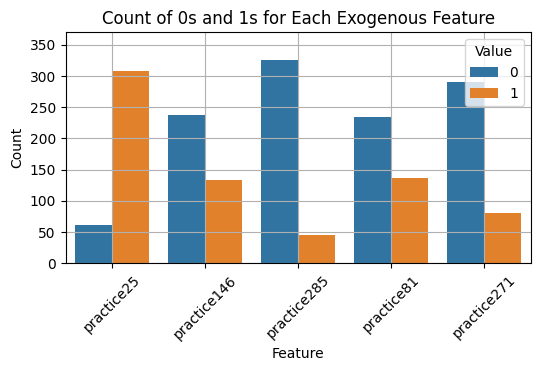

In [30]:
# Extract exogenous features (excluding the target variable and identifiers)
exogenous_features = evaluations.drop(['project', 'date', 'nps'], axis=1)

# Calculate counts of 0s and 1s for each feature
counts = {}
for column in exogenous_features.columns:
    counts[column] = {
        '0': (exogenous_features[column] == 0).sum(),
        '1': (exogenous_features[column] == 1).sum()
    }

# Convert counts to DataFrame for easy plotting
counts_df = pd.DataFrame(counts).T
counts_df = counts_df.reset_index().rename(columns={'index': 'Feature'})
counts_df = counts_df.melt(id_vars='Feature', var_name='Value', value_name='Count')

# Plot
plt.figure(figsize=(6, 3))
sns.barplot(x='Feature', y='Count', hue='Value', data=counts_df)
plt.title('Count of 0s and 1s for Each Exogenous Feature')
plt.xlabel('Feature')
plt.ylabel('Count')
plt.ylim(0, len(evaluations))
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Value')
plt.grid(True)
plt.show()

To ensure better feature variability and avoid rank-deficient features, this study will remove features from the main DataFrame where the total count is smaller than 50.

In [31]:
to_drop = counts_df[(counts_df['Count'] < 50)]
evaluations = evaluations.drop(columns=to_drop['Feature'])
evaluations

project       date  nps  practice25  practice146  practice81  \
0     Project1 2021-06-01   25         1.0          0.0         0.0   
1     Project1 2021-07-01   25         1.0          0.0         0.0   
2     Project1 2021-08-01   25         1.0          0.0         0.0   
3     Project1 2021-09-01   25         1.0          0.0         0.0   
4     Project1 2021-10-01   25         1.0          0.0         0.0   
..         ...        ...  ...         ...          ...         ...   
365  Project10 2024-02-01   50         1.0          1.0         1.0   
366  Project10 2024-03-01   50         1.0          1.0         1.0   
367  Project10 2024-04-01   39         1.0          1.0         1.0   
368  Project10 2024-05-01   28         1.0          1.0         1.0   
369  Project10 2024-06-01   17         1.0          1.0         1.0   

     practice271  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  
..           ...  
365          1.0  
366          1.0  
367          1.0  
368          1.0  
369          1.0  

[370 rows x 7 columns]

Save the final DataFrame to a .csv file.

In [32]:
#Output as a file.
evaluations.to_csv(tcc_folder + 'data/tcc-data_digested.csv', index=False)

**3.3. Implementation of Artificial Intelligence Algorithms**

The combined dataset, which includes best practices survey responses and net promoter scores from the first section, is ready for use with artificial intelligence algorithms. In the next code snippet, the prepared CSV file is loaded into a DataFrame.

Load the prepared csv file in a DataFrame.

In [ ]:
# Import libraries
import numpy as np
import pandas as pd

# Mount Google Drive to this environment
from google.colab import drive
drive.mount('/content/gdrive')
tcc_folder = 'gdrive/My Drive/[Pós] AI and Big Data-USP/TCC/'

# Load csv resulting data source
data = pd.read_csv(tcc_folder + 'data/tcc-data_digested.csv')

evaluations = pd.DataFrame(data)
evaluations['date'] = pd.to_datetime(evaluations['date'], infer_datetime_format=True)

# Print data frame
evaluations

Mounted at /content/gdrive


<ipython-input-4-30eb73bfcf80>:14: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  evaluations['date'] = pd.to_datetime(evaluations['date'], infer_datetime_format=True)


project       date  nps  practice25  practice146  practice81  \
0     Project1 2021-06-01   25         1.0          0.0         0.0   
1     Project1 2021-07-01   25         1.0          0.0         0.0   
2     Project1 2021-08-01   25         1.0          0.0         0.0   
3     Project1 2021-09-01   25         1.0          0.0         0.0   
4     Project1 2021-10-01   25         1.0          0.0         0.0   
..         ...        ...  ...         ...          ...         ...   
365  Project10 2024-02-01   50         1.0          1.0         1.0   
366  Project10 2024-03-01   50         1.0          1.0         1.0   
367  Project10 2024-04-01   39         1.0          1.0         1.0   
368  Project10 2024-05-01   28         1.0          1.0         1.0   
369  Project10 2024-06-01   17         1.0          1.0         1.0   

     practice271  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  
..           ...  
365          1.0  
366          1.0  
367          1.0  
368          1.0  
369          1.0  

[370 rows x 7 columns]

The framework utilized in this study requires the target attribute (nps), date (date), and identifiers (project) to be renamed as 'y', 'ds', and 'unique_id' respectively.

In the following code snippet, the attributes of our dataset are renamed to meet this requirement.

In [ ]:
# MLForecast framework requires that the target attribute to be renamed to 'y', and the id attribute to be renamed to 'unique_id'
evaluations = evaluations.rename(columns={'nps': 'y', 'date': 'ds', 'project': 'unique_id'})
evaluations

unique_id         ds   y  practice25  practice146  practice81  \
0     Project1 2021-06-01  25         1.0          0.0         0.0   
1     Project1 2021-07-01  25         1.0          0.0         0.0   
2     Project1 2021-08-01  25         1.0          0.0         0.0   
3     Project1 2021-09-01  25         1.0          0.0         0.0   
4     Project1 2021-10-01  25         1.0          0.0         0.0   
..         ...        ...  ..         ...          ...         ...   
365  Project10 2024-02-01  50         1.0          1.0         1.0   
366  Project10 2024-03-01  50         1.0          1.0         1.0   
367  Project10 2024-04-01  39         1.0          1.0         1.0   
368  Project10 2024-05-01  28         1.0          1.0         1.0   
369  Project10 2024-06-01  17         1.0          1.0         1.0   

     practice271  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  
..           ...  
365          1.0  
366          1.0  
367          1.0  
368          1.0  
369          1.0  

[370 rows x 7 columns]

**3.3.1 Splitting the DataFrame into training and testing sets**

Now the data source will be split into training and testing sets. Our time series contains data from June 2021 to June 2024, with a total of 370 rows.

In a time series problem, the dataset is typically split based on a cutoff date. The portion of the time series before the cutoff date will form the training set, while the portion after the cutoff date will form the testing set.

In this study, we will use September 2023 as the cutoff date for the split. The larger part will be used for training, while the smaller part will be used to test the performance of the models.

The resulting training and testing data sets contain 290 and 80 rows, respectively, representing a ratio of approximately 72% and 27%.

In [ ]:
# Split data into train and test
train = evaluations.loc[evaluations['ds'] < '2023-11-01']
test = evaluations.loc[evaluations['ds'] >= '2023-11-01']
train.shape, test.shape

((290, 7), (80, 7))

The complete time series and its division into training and test sets can be visualized in the chart below:

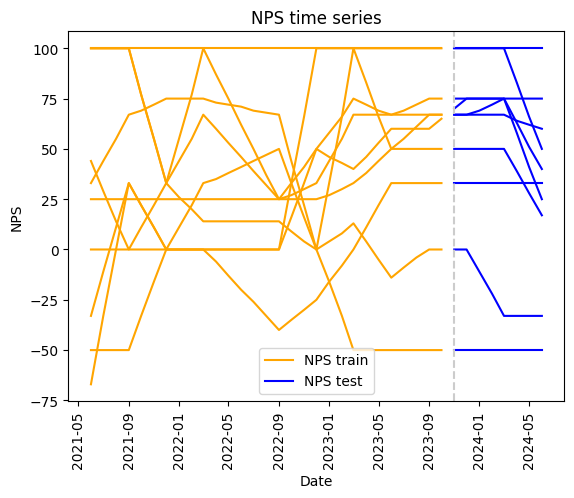

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import time
import datetime

#get projects list
projects_in_file = evaluations['unique_id'].tolist()
projects_list = sorted(list(set(projects_in_file)))

for project in projects_list:
  y_train = train[train.unique_id == project].y
  x_train = train[train.unique_id == project].ds
  plt.plot(x_train, y_train, label = project, color = 'orange')

  y_test = test[test.unique_id == project].y
  x_test = test[test.unique_id == project].ds
  plt.plot(x_test, y_test, label = project, color = 'blue')


# Add the cutoff line
cutoff = datetime.datetime.strptime("2023-11-01", "%Y-%m-%d")
plt.axvline(x=cutoff, color='#ccc', linestyle='--')

plt.legend(['NPS train', 'NPS test'])
plt.title('NPS time series')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('NPS')
plt.show()


**3.3.2 Implementation**

**3.3.2.1 Random Forest (RF), Extreme Gradient Boosting (XGBoost) and Lasso**

During this experiment, a framework called mlforecast will be utilized.

**mlforecast** is a framework to perform time series forecasting using machine learning models, with the option to scale to massive amounts of data using remote clusters.

https://github.com/Nixtla/mlforecast

The mlforecast framework supports regressors that follow the scikit-learn API. Therefore, in the next part, three artificial intelligence algorithms based on the scikit-learn API will be implemented: Random Forest, XGBoost, and LASSO.

In [ ]:
%pip install mlforecast matplotlib xgboost statsforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.6/134.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour i

The number of forecast periods is calculated in the next code snippet. The calculation is based on the total number of rows in the testing DataFrame divided by the total number of unique projects (time series).

The testing DataFrame has 80 rows and there are 10 different projects. Therefore, the total number of forecast periods is 8.

In [ ]:
# Calculate the number of forecast periods
h = int(test.shape[0]/projects_list.__len__())

In the next code snippet, the RandomForest and Lasso regressors are imported from sklearn. The XGBRegressor is imported from the xgboost library, but it is also compatible with the scikit-learn API. The regressors are instantiated and combined in a pipeline, which will be passed to the MLForecast method as an argument.

The relevant parameters for each model, along with the values that demonstrated the best results in this study, are described in the table below.

In addition to the pipeline of models, the mlforecast library has several relevant parameters that simplify working with time series. These parameters are described below.

In [ ]:
# Import sklearn Random Forest and Lasso regressors.
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso

from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
# Import XGBoost regressor.
from xgboost import XGBRegressor
# Import mlforecast library
from mlforecast import MLForecast

# Random Forest Model.
RandomForest_model = RandomForestRegressor(random_state=0, n_estimators=100)
# XGBRegressor Model.
XGBRegressor_model = XGBRegressor(random_state=0, n_estimators=100)
# Lasso Model.
Lasso_model = Lasso(alpha=0.1, max_iter=10000)
# Make a Pipeline with those Models.
models = [make_pipeline(SimpleImputer(),
                        RandomForest_model),
                        XGBRegressor_model,
                        Lasso_model]
# Use MLForecast framework passing the parameters.
model = MLForecast(models=models,
                   freq='MS',
                   lags=[1,2],
                   date_features=[])
# Train the model using training data.
model.fit(train, id_col='unique_id', time_col='ds', target_col='y', static_features=[], max_horizon=h)
# Generate the prediction of the next h values of NPS.
p = model.predict(h=h, X_df=test)
# Merge the results of the testing DataFrame with the resulting prediction for further comparission.
p = p.merge(test[['unique_id', 'ds', 'y']], on=['unique_id', 'ds'], how='left')
# Display the DataFrame.
p

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


unique_id         ds  RandomForestRegressor  XGBRegressor       Lasso    y
0   Project1 2023-11-01                 67.000     66.989334   65.097419   67
1   Project1 2023-12-01                 67.000     66.973457   62.251719   67
2   Project1 2024-01-01                 66.720     66.829491   60.076633   69
3   Project1 2024-02-01                 64.730     66.847046   58.461191   72
4   Project1 2024-03-01                 62.615     66.799301   56.414591   75
..       ...        ...                    ...           ...         ...  ...
75  Project9 2024-02-01                100.000    100.007545  101.495887  100
76  Project9 2024-03-01                100.000    100.009041  103.219946  100
77  Project9 2024-04-01                100.000     99.997604  105.351913   83
78  Project9 2024-05-01                100.000     99.998619  107.031876   66
79  Project9 2024-06-01                100.000    100.037148  107.042522   50

[80 rows x 6 columns]

**3.3.2.2 AutoARIMA**

In this study, a framework called "StatsForecast" was used.  StatsForecast offers a collection of widely used univariate time series forecasting models, including AutoARIMA. In the AutoARIMA implementation, the best ARIMA (AutoRegressive Integrated Moving Average) model is automatically selected using an information criterion.

In this experiment, the default parameters of AutoARIMA were used without any customizations.



In [ ]:
# Import StatsForecast and AutoARIMA.
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

# Create an array containing AutoARIMA instantiation.
models = [AutoARIMA()]

# Use StatsForecast method passing the model and the frequecy as parameters.
sf = StatsForecast(
    models=models,
    freq='MS',
)
# Train the model using training data.
sf.fit(train, id_col='unique_id', time_col='ds', target_col='y')
# Generate the prediction of the next h values of NPS.
q = sf.predict(h=h, X_df=test.loc[:, test.columns!='y'])
# Merge the results of the testing DataFrame with the resulting prediction for further comparission.
q = q.merge(p, on=['unique_id', 'ds'], how='left')
# Display the DataFrame.
q

/usr/local/lib/python3.10/dist-packages/statsforecast/arima.py:654: RuntimeWarning: divide by zero encountered in scalar divide
  mod["Pn"][0, 0] = 1 / (1 - phi[0] ** 2) if p > 0 else 1
/usr/local/lib/python3.10/dist-packages/statsforecast/arima.py:654: RuntimeWarning: divide by zero encountered in scalar divide
  mod["Pn"][0, 0] = 1 / (1 - phi[0] ** 2) if p > 0 else 1
/usr/local/lib/python3.10/dist-packages/statsforecast/arima.py:654: RuntimeWarning: divide by zero encountered in scalar divide
  mod["Pn"][0, 0] = 1 / (1 - phi[0] ** 2) if p > 0 else 1
/usr/local/lib/python3.10/dist-packages/statsforecast/arima.py:654: RuntimeWarning: divide by zero encountered in scalar divide
  mod["Pn"][0, 0] = 1 / (1 - phi[0] ** 2) if p > 0 else 1
/usr/local/lib/python3.10/dist-packages/statsforecast/arima.py:1612: UserWarning: xreg not required by this model, ignoring the provided regressors
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning: In a futu

unique_id         ds   AutoARIMA  RandomForestRegressor  XGBRegressor  \
0   Project1 2023-11-01   63.093430                 67.000     66.989334   
1   Project1 2023-12-01   59.186855                 67.000     66.973457   
2   Project1 2024-01-01   55.280285                 66.720     66.829491   
3   Project1 2024-02-01   51.373714                 64.730     66.847046   
4   Project1 2024-03-01   47.467140                 62.615     66.799301   
..       ...        ...         ...                    ...           ...   
75  Project9 2024-02-01  100.000000                100.000    100.007545   
76  Project9 2024-03-01  100.000000                100.000    100.009041   
77  Project9 2024-04-01  100.000000                100.000     99.997604   
78  Project9 2024-05-01  100.000000                100.000     99.998619   
79  Project9 2024-06-01  100.000000                100.000    100.037148   

         Lasso    y  
0    65.097419   67  
1    62.251719   67  
2    60.076633   69  
3    58.461191   72  
4    56.414591   75  
..         ...  ...  
75  101.495887  100  
76  103.219946  100  
77  105.351913   83  
78  107.031876   66  
79  107.042522   50  

[80 rows x 7 columns]

**3.3.2.3 Long Short-Term Memory (LSTM)**

The final model implemented in this study is LSTM. A framework called "NeuralForecast" was used for this purpose. "NeuralForecast" offers a wide range of neural forecasting models, emphasizing performance, usability, and robustness. The models include classic networks like RNNs, as well as LSTM, which is used in this study.

The following code snippet imports the "neuralforecast" library.

In [ ]:
%pip install neuralforecast

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

The parameters utilized in the LSTM model are described in the table below:


In the code snippet below, the model is implemented by first creating a list that includes the LSTM model. The "NeuralForecast" method is then used, passing the model list and the frequency of the time series. The model is trained, and a DataFrame containing the predictions is generated.

The resulting DataFrame is displayed below. It includes columns with predictions from RandomForest, XGB, Lasso, AutoARIMA, and LSTM, as well as the actual values from the test DataFrame.

In [ ]:
# Import NeuralForecast and LSTM.
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM
from neuralforecast.losses.pytorch import DistributionLoss
# Get the exogenous features, excluding the id, date and nps columns.
relevant_columns = evaluations.drop(columns=['unique_id','ds','y']).columns.values
relevant_columns = relevant_columns.tolist()
# Prepare models list containig LTSM, passing the configuration parameters.
models = [LSTM(h=h,
               loss=DistributionLoss(distribution='Normal', level=[90]),
               max_steps=14500,
               encoder_n_layers=3,
               encoder_hidden_size=100,
               context_size=1,
               decoder_hidden_size=100,
               decoder_layers=3,
               learning_rate=1e-5,
               scaler_type='standard',
               futr_exog_list=relevant_columns)]

# Use NeuralForecast method passing the model list and the frequecy as parameters.
model = NeuralForecast(models=models, freq='MS')
# Train the model using training data.
model.fit(train)
# Generate the prediction.
predicted =  model.predict(futr_df=test).reset_index()
# Merge the results of the testing DataFrame with the resulting prediction for further comparission.
predicted = predicted.merge(q, on=['unique_id', 'ds'], how='left')
# Display the DataFrame
predicted

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | loss            | DistributionLoss | 3      | train
1 | padder          | ConstantPad1d    | 0      | train
2 | scaler          | TemporalNorm     | 0      | train
3 | hist_encoder    | LSTM             | 202 K  | train
4 | context_adapter | Linear           | 1.1 K  | train
5 | mlp_decoder     | MLP              | 10.9 K | train
-------------------------------------------------------------
214 K     Trainable params
3         Non-trainable params
214 K     Total params
0.859     Total estimated model params size (MB)
13        Modul

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=14500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


unique_id         ds        LSTM  LSTM-median  LSTM-lo-90  LSTM-hi-90  \
0   Project1 2023-11-01   67.558517    67.584656   63.055260   72.208786   
1   Project1 2023-12-01   68.963539    68.947174   64.481270   73.587357   
2   Project1 2024-01-01   66.192703    66.170532   61.611740   70.558792   
3   Project1 2024-02-01   67.459572    67.470169   63.348423   71.881508   
4   Project1 2024-03-01   70.672836    70.641815   66.166344   75.065010   
..       ...        ...         ...          ...         ...         ...   
75  Project9 2024-02-01  100.010979   100.011612   99.675987  100.356201   
76  Project9 2024-03-01  100.035767   100.033226   99.723106  100.381882   
77  Project9 2024-04-01  100.076096   100.082603   99.734657  100.390320   
78  Project9 2024-05-01  100.142967   100.143311   99.813080  100.472610   
79  Project9 2024-06-01  100.180885   100.182869   99.849396  100.528122   

     AutoARIMA  RandomForestRegressor  XGBRegressor       Lasso    y  
0    63.093430                 67.000     66.989334   65.097419   67  
1    59.186855                 67.000     66.973457   62.251719   67  
2    55.280285                 66.720     66.829491   60.076633   69  
3    51.373714                 64.730     66.847046   58.461191   72  
4    47.467140                 62.615     66.799301   56.414591   75  
..         ...                    ...           ...         ...  ...  
75  100.000000                100.000    100.007545  101.495887  100  
76  100.000000                100.000    100.009041  103.219946  100  
77  100.000000                100.000     99.997604  105.351913   83  
78  100.000000                100.000     99.998619  107.031876   66  
79  100.000000                100.000    100.037148  107.042522   50  

[80 rows x 11 columns]

In [ ]:
#Output as a file.
predicted.to_csv(tcc_folder + 'data/predicted.csv', index=False)

**3.4 Repeating the experiment after removing the exogenous features**

In this section, the same AI algorithms are retrained, but this time excluding the four practices from the DataFrame that were used as exogenous features. The goal is to determine whether these exogenous features positively influence the performance of the AI models.

In the following code snippet, a new DataFrame is prepared by excluding the exogenous features. It is then split into test and train datasets using the same cutoff as in the previous experiments.

In [ ]:
# Create e new dataframe based on the original one.
evaluations_without_exog = evaluations.drop(columns=['practice25',	'practice146',	'practice81',	'practice271'])

# Split data into train and test
train_without_exog = evaluations_without_exog.loc[evaluations['ds'] < '2023-11-01']
test_without_exog = evaluations_without_exog.loc[evaluations['ds'] >= '2023-11-01']
train_without_exog.shape, test_without_exog.shape

((290, 3), (80, 3))

Retrained all the 5 models used in the previous study.

In [17]:
###Re-implement the AI algorithms
# Import sklearn Random Forest and Lasso regressors.
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso

from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
# Import XGBoost regressor.
from xgboost import XGBRegressor
# Import mlforecast library
from mlforecast import MLForecast

# Random Forest Model.
RandomForest_model = RandomForestRegressor(random_state=0, n_estimators=100)
# XGBRegressor Model.
XGBRegressor_model = XGBRegressor(random_state=0, n_estimators=100)
# Lasso Model.
Lasso_model = Lasso(alpha=0.1, max_iter=10000)
# Make a Pipeline with those Models.
models = [make_pipeline(SimpleImputer(),
                        RandomForest_model),
                        XGBRegressor_model,
                        Lasso_model]
# Use MLForecast framework passing the parameters.
model = MLForecast(models=models,
                   freq='MS',
                   lags=[1,2],
                   date_features=[])
# Train the model using training data.
model.fit(train_without_exog, id_col='unique_id', time_col='ds', target_col='y', static_features=[], max_horizon=h)
# Generate the prediction of the next h values of NPS.
p = model.predict(h=h, X_df=test_without_exog)
# Merge the results of the testing DataFrame with the resulting prediction for further comparission.
p = p.merge(test_without_exog[['unique_id', 'ds', 'y']], on=['unique_id', 'ds'], how='left')
# Display the DataFrame.


# Import StatsForecast and AutoARIMA.
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

# Create an array containing AutoARIMA instantiation.
models = [AutoARIMA()]

# Use StatsForecast method passing the model and the frequecy as parameters.
sf = StatsForecast(
    models=models,
    freq='MS',
)
# Train the model using training data.
sf.fit(train_without_exog, id_col='unique_id', time_col='ds', target_col='y')
# Generate the prediction of the next h values of NPS.
q = sf.predict(h=h, X_df=test_without_exog.loc[:, test_without_exog.columns!='y'])
# Merge the results of the testing DataFrame with the resulting prediction for further comparission.
q = q.merge(p, on=['unique_id', 'ds'], how='left')
# Display the DataFrame.

# Import NeuralForecast and LSTM.
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM
from neuralforecast.losses.pytorch import DistributionLoss

# Prepare models list containig LTSM, passing the configuration parameters.
models = [LSTM(h=h,
               loss=DistributionLoss(distribution='Normal', level=[90]),
               max_steps=14500,
               encoder_n_layers=3,
               encoder_hidden_size=100,
               context_size=1,
               decoder_hidden_size=100,
               decoder_layers=3,
               learning_rate=1e-5,
               scaler_type='standard',
               futr_exog_list=[])]

# Use NeuralForecast method passing the model list and the frequecy as parameters.
model = NeuralForecast(models=models, freq='MS')
# Train the model using training data.
model.fit(train_without_exog)
# Generate the prediction.
predicted_without_exog =  model.predict(futr_df=test_without_exog).reset_index()
# Merge the results of the testing DataFrame with the resulting prediction for further comparission.
predicted_without_exog = predicted_without_exog.merge(q, on=['unique_id', 'ds'], how='left')
# Display the DataFrame
predicted_without_exog

/usr/local/lib/python3.10/dist-packages/statsforecast/arima.py:1612: UserWarning: xreg not required by this model, ignoring the provided regressors
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | loss            | DistributionLoss | 3      | train
1 | padder          | ConstantPad1d    | 0   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=14500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


unique_id         ds        LSTM  LSTM-median  LSTM-lo-90  LSTM-hi-90  \
0   Project1 2023-11-01   66.138657    66.164795   61.635406   70.788918   
1   Project1 2023-12-01   65.497200    65.480835   61.014935   70.121017   
2   Project1 2024-01-01   65.733139    65.710968   61.152191   70.099213   
3   Project1 2024-02-01   66.034393    66.044998   61.923252   70.456322   
4   Project1 2024-03-01   53.284611    53.253578   48.778114   57.676777   
..       ...        ...         ...          ...         ...         ...   
75  Project9 2024-02-01  100.113594   100.114227   99.778809  100.458618   
76  Project9 2024-03-01  100.065247   100.062714   99.752701  100.411240   
77  Project9 2024-04-01  100.264511   100.271004   99.923187  100.578598   
78  Project9 2024-05-01   99.921928    99.922272   99.592033  100.251579   
79  Project9 2024-06-01  100.299149   100.301132   99.967735  100.646317   

     AutoARIMA  RandomForestRegressor  XGBRegressor      Lasso    y  
0    63.093430              67.000000     66.990402  65.900864   67  
1    59.186855              67.000000     66.941948  64.307007   67  
2    55.280285              67.080000     66.919792  62.914310   69  
3    51.373714              65.630000     66.878868  62.077896   72  
4    47.467140              65.806667     66.987030  61.649261   75  
..         ...                    ...           ...        ...  ...  
75  100.000000              91.390522     90.953972  87.568237  100  
76  100.000000              91.360614     91.076508  86.046181  100  
77  100.000000              93.524712     93.668900  84.984032   83  
78  100.000000              95.082992     94.850754  83.219887   66  
79  100.000000              94.712581     94.354156  81.148201   50  

[80 rows x 11 columns]

In [18]:
predicted_without_exog.to_csv(tcc_folder + 'data/predicted_without_exog.csv', index=False)

**4. Experimental Evaluation**

In this section, we will introduce the approach for evaluating the accuracy of the time series forecasting models implemented in the previous section. This will be followed by a comparison of all the implemented models, enabling analysis and further conclusions.

**4.1 Evaluating Forecasting Model Accuracy**

In [19]:
# Mount Google Drive to this environment
from google.colab import drive
drive.mount('/content/gdrive')
tcc_folder = 'gdrive/My Drive/[Pós] AI and Big Data-USP/TCC/'

# Load csv resulting data source
predicted = pd.read_csv(tcc_folder + 'data/predicted.csv')
predicted_without_exog = pd.read_csv(tcc_folder + 'data/predicted_without_exog.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [24]:
# Import metrics functions from sklearn.
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Define the SMAPE function.
def smape(actual, prediction):
    smape = 1/len(actual)*np.sum(np.abs(prediction-actual)/(np.abs(actual) + np.abs(prediction))*100)
    return smape

# Define the models list as a list of lists.
models_list = [["Random Forest", "RandomForestRegressor"],
               ["XGBRegressor", "XGBRegressor"],
               ["Lasso", "Lasso"],
               ["AutoARIMA", "AutoARIMA"],
               ["LSTM", "LSTM"]]

# Calculate the metrics for each model.
for model in models_list:
    model_name = model[0]
    model_col = model[1]
    mae = round(mean_absolute_error(predicted['y'], predicted[model_col]), 4)
    rmse = round(np.sqrt(mean_squared_error(predicted['y'], predicted[model_col])), 4)
    mse = round(mean_squared_error(predicted['y'], predicted[model_col]), 4)
    smape_value = round(smape(predicted['y'], predicted[model_col]), 4)
    # Add metrics to the model list
    model.extend([mae, rmse, mse, smape_value])

# Create a DataFrame from the list of lists
smape_list_df = pd.DataFrame(models_list, columns=['Model', 'Model Column', 'MAE', 'RMSE', 'MSE', 'sMAPE'])
# Display the DataFrame
smape_list_df

Model           Model Column      MAE     RMSE       MSE    sMAPE
0  Random Forest  RandomForestRegressor   9.5087  16.8713  284.6395  12.8735
1   XGBRegressor           XGBRegressor   9.6862  18.1290  328.6604  12.1817
2          Lasso                  Lasso  12.5806  17.7693  315.7470  20.0351
3      AutoARIMA              AutoARIMA  14.2040  19.5156  380.8583  24.2189
4           LSTM                   LSTM   9.6868  16.2052  262.6097  15.9755

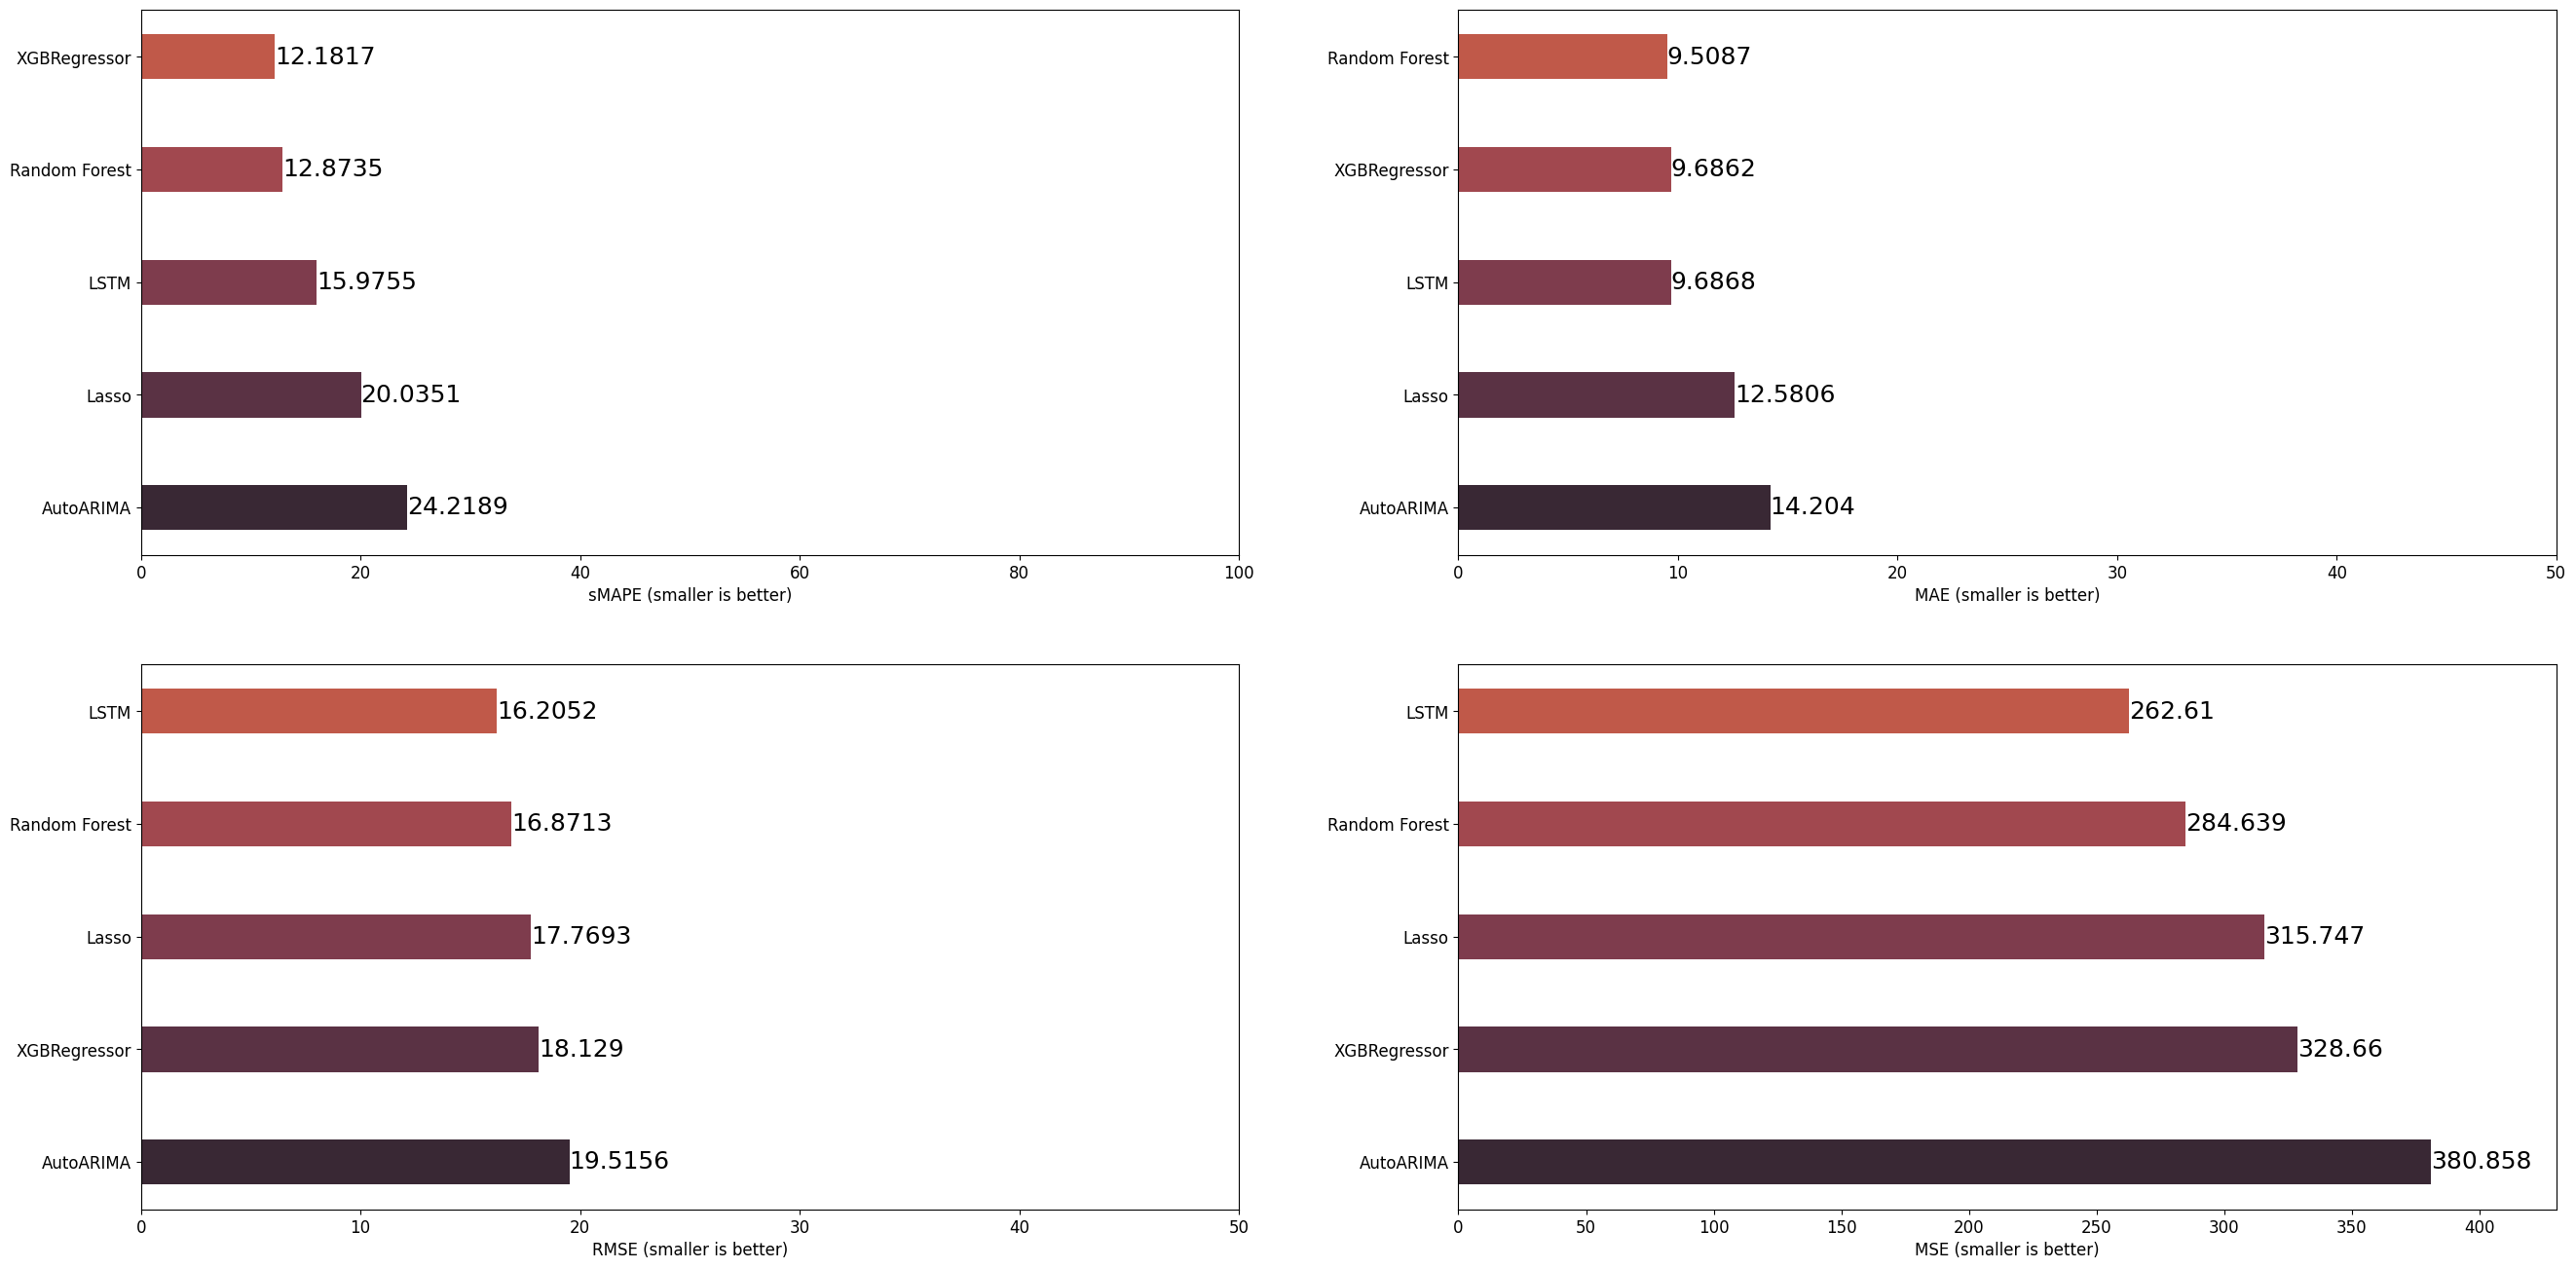

In [25]:
# Display a chart with the distribution of nps per project
import matplotlib.pyplot as plt
plt.close('all')

colors = ["#392834", "#5a3244", "#7e3c4d", "#a1484f", "#c05949"]

def plot_chart(ax, xlabel, x, y, scale):
    bars = ax.barh(y=range(len(x)), tick_label=x, width=y, height=0.4, color=colors)
    ax.set(xlabel=xlabel)
    ax.bar_label(bars, fontsize=18)
    ax.set_xlim(0, scale)


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(32, 16)

smape_list_df = smape_list_df.sort_values(by=['sMAPE', 'Model'], ascending=[False, True])
plot_chart(ax1, "sMAPE (smaller is better)", smape_list_df['Model'], smape_list_df['sMAPE'], 100)
smape_list_df = smape_list_df.sort_values(by=['MAE', 'Model'], ascending=[False, True])
plot_chart(ax2, "MAE (smaller is better)", smape_list_df['Model'], smape_list_df['MAE'], 50)
smape_list_df = smape_list_df.sort_values(by=['RMSE', 'Model'], ascending=[False, True])
plot_chart(ax3, "RMSE (smaller is better)", smape_list_df['Model'], smape_list_df['RMSE'], 50)
smape_list_df = smape_list_df.sort_values(by=['MSE', 'Model'], ascending=[False, True])
plot_chart(ax4, "MSE (smaller is better)", smape_list_df['Model'], smape_list_df['MSE'], 430)

In the following code snippet, the actual NPS scores from the test DataFrame are compared with the predicted values from each model for each project.

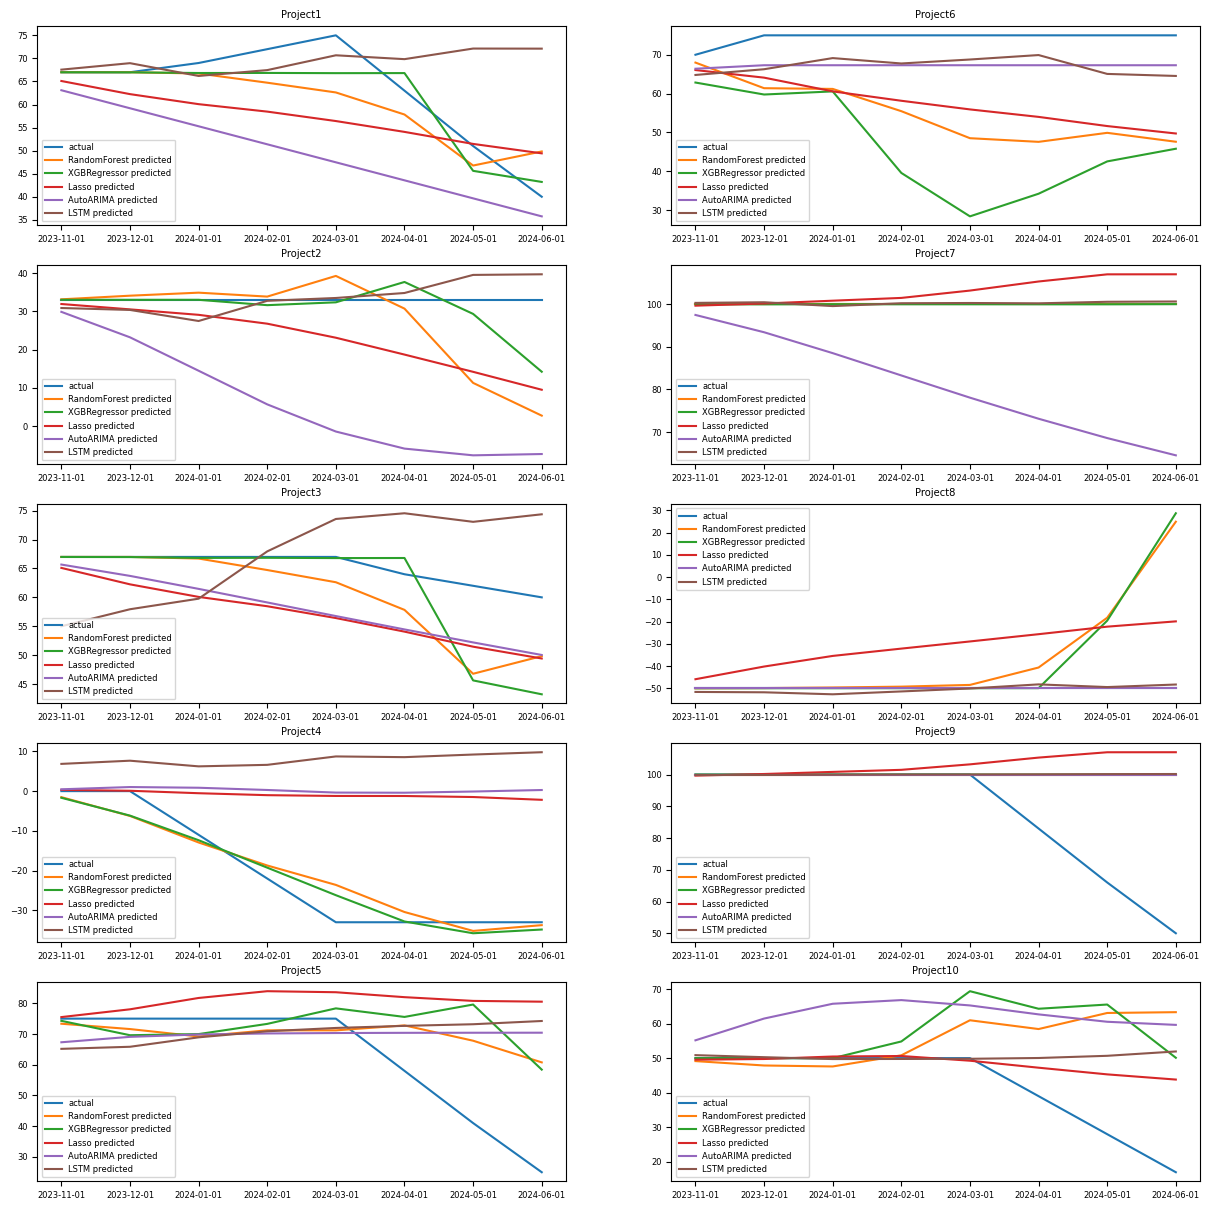

In [26]:
from matplotlib import pyplot as plt
from natsort import natsorted

plt.rcParams.update({'font.size': 6})

sorted_projects = natsorted(projects_list)

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(5, 2)
x_index = 0
y_index = 0

figure.set_size_inches(15, 15)

for project in sorted_projects:
  project_result = predicted[predicted.unique_id == project]
  axis[x_index, y_index].set_title(project)
  axis[x_index, y_index].plot(project_result.ds, project_result.y, label='actual')
  axis[x_index, y_index].plot(project_result.ds, project_result.RandomForestRegressor, label='RandomForest predicted')
  axis[x_index, y_index].plot(project_result.ds, project_result.XGBRegressor, label='XGBRegressor predicted')
  axis[x_index, y_index].plot(project_result.ds, project_result.Lasso, label='Lasso predicted')
  axis[x_index, y_index].plot(project_result.ds, project_result.AutoARIMA, label='AutoARIMA predicted')
  axis[x_index, y_index].plot(project_result.ds, project_result.LSTM, label='LSTM predicted')
  axis[x_index, y_index].legend()
  x_index += 1
  if x_index > 4:
    x_index = 0
    y_index += 1

plt.show()


A scatter plot is created to compare actual values with predicted values for each model, helping to understand the dispersion of the predictions.

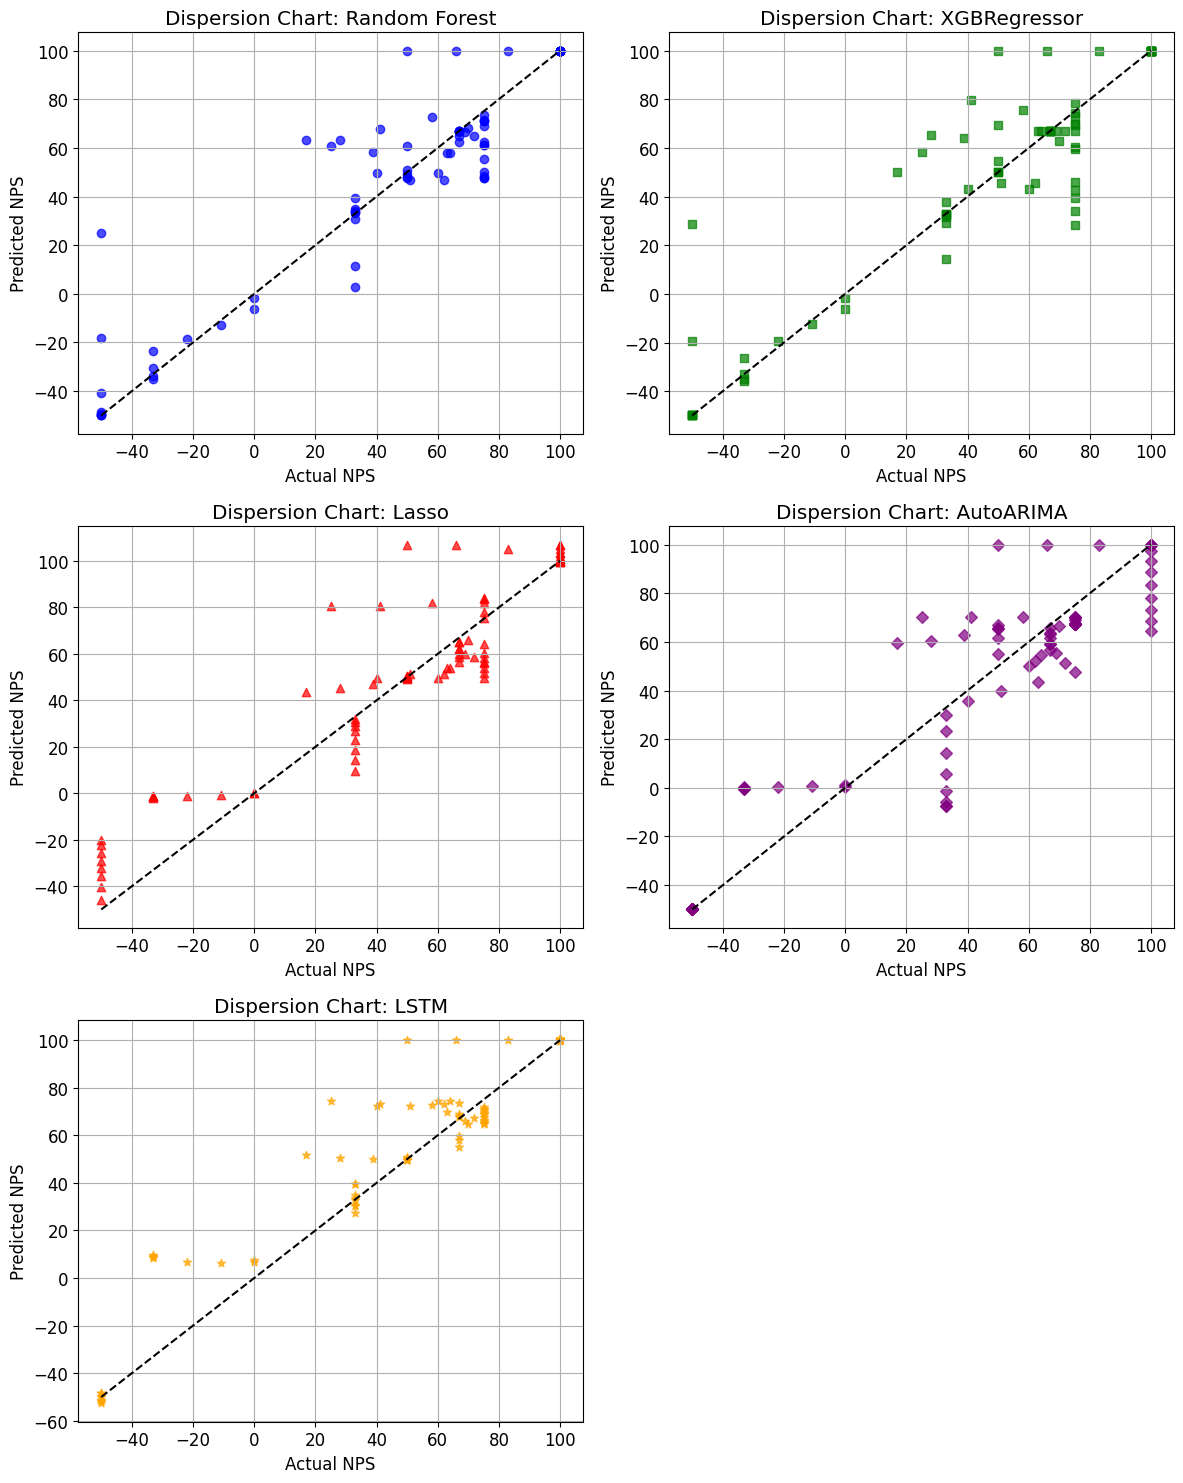

In [31]:
from matplotlib import pyplot as plt

plt.rcParams.update({'font.size': 12})  # Adjust font size if needed

# Initialize the plot with a 2x3 grid layout
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Define a color map or markers for each model for better distinction
colors = ['blue', 'green', 'red', 'purple', 'orange']
markers = ['o', 's', '^', 'D', '*']

# Plot data for each model
for i, model in enumerate(models_list):
    model_name = model[0]
    model_col = model[1]

    # Select the current axis for plotting
    ax = axes[i]

    # Filter data for the current model
    model_data = predicted[model_col]

    # Plot scatter for the current model
    ax.scatter(predicted['y'], model_data, color=colors[i % len(colors)],
               alpha=0.7, marker=markers[i % len(markers)])

    # Plot the diagonal line
    ax.plot([predicted['y'].min(), predicted['y'].max()],
            [predicted['y'].min(), predicted['y'].max()], color='black', linestyle='--')

    # Set labels and title
    ax.set_xlabel('Actual NPS')
    ax.set_ylabel('Predicted NPS')
    ax.set_title(f'Dispersion Chart: {model_name}')
    ax.grid(True)

# Hide the empty subplot if it exists
if len(models_list) < len(axes):
    for j in range(len(models_list), len(axes)):
        axes[j].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [29]:
print(models_list)

[['Random Forest', 'RandomForestRegressor', 9.5087, 16.8713, 284.6395, 12.8735], ['XGBRegressor', 'XGBRegressor', 9.6862, 18.129, 328.6604, 12.1817], ['Lasso', 'Lasso', 12.5806, 17.7693, 315.747, 20.0351], ['AutoARIMA', 'AutoARIMA', 14.204, 19.5156, 380.8583, 24.2189], ['LSTM', 'LSTM', 9.6868, 16.2052, 262.6097, 15.9755]]


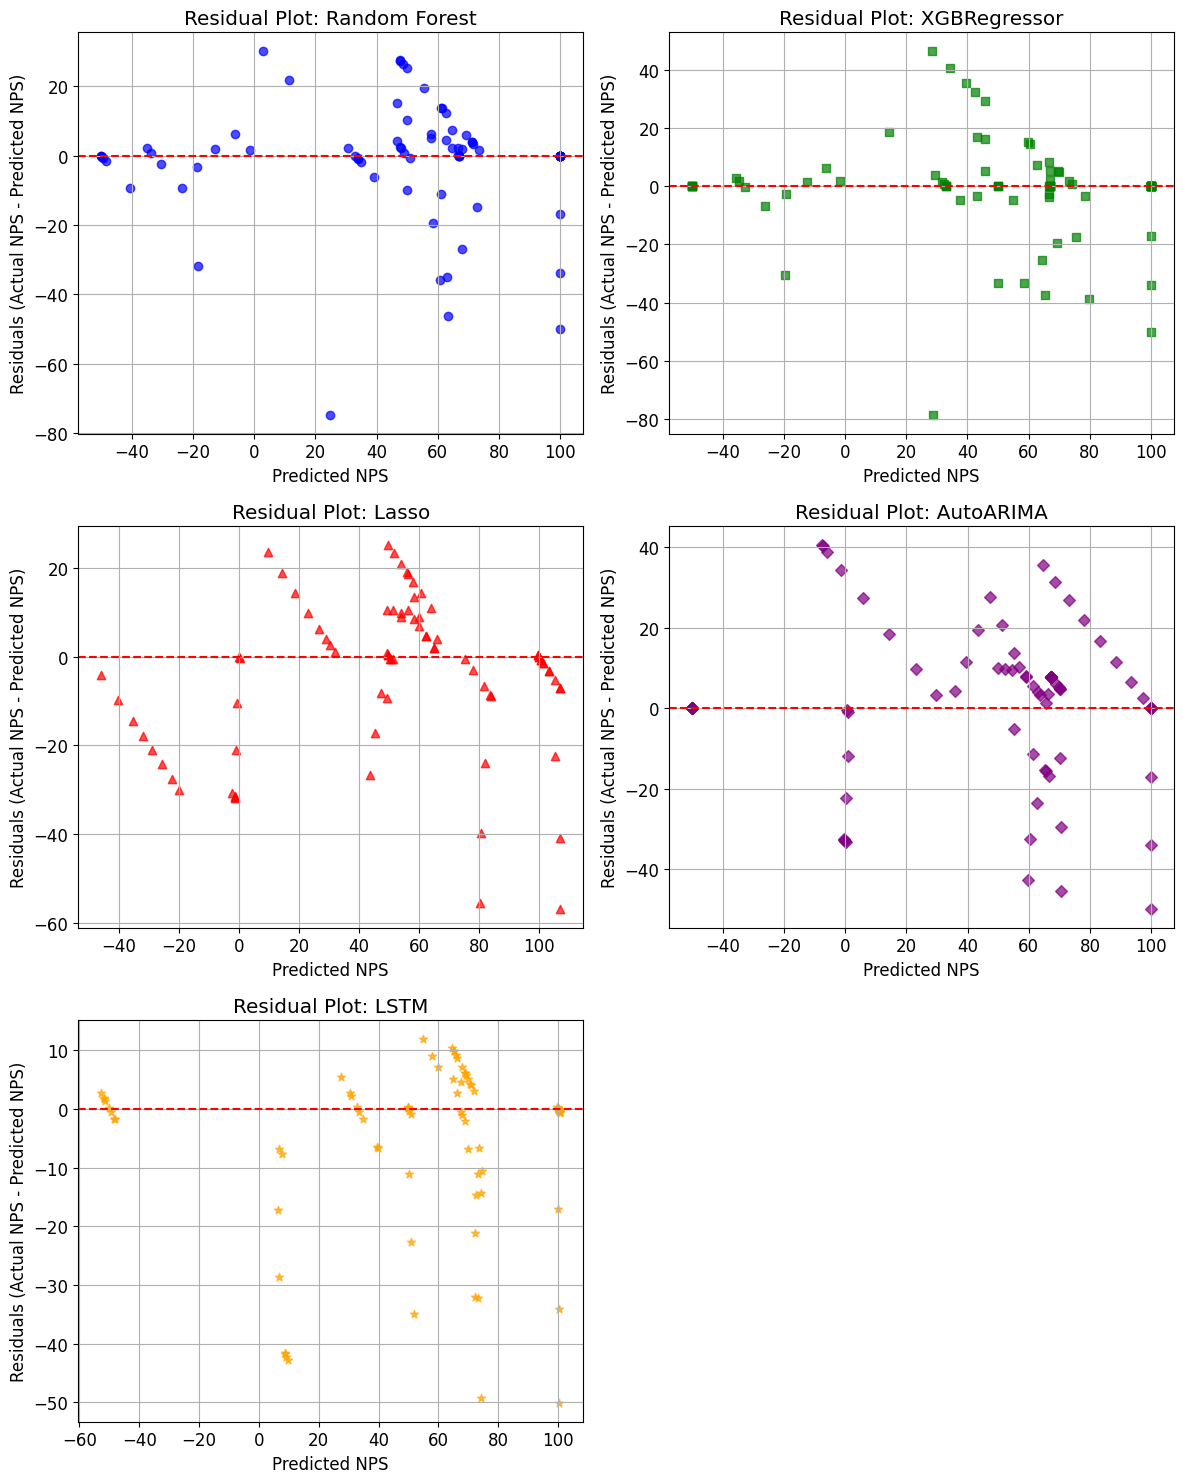

In [32]:
from matplotlib import pyplot as plt

plt.rcParams.update({'font.size': 12})  # Adjust font size if needed

# Initialize the plot
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Define a color map or markers for each model for better distinction
colors = ['blue', 'green', 'red', 'purple', 'orange']
markers = ['o', 's', '^', 'D', '*']

# Plot data for each model
for i, model in enumerate(models_list):
    model_name = model[0]
    model_col = model[1]
    residuals = predicted['y'] - predicted[model_col]
    axes[i].scatter(predicted[model_col], residuals, color=colors[i % len(colors)], alpha=0.7, marker=markers[i % len(markers)],label=model_name)
    axes[i].axhline(y=0, color='red', linestyle='--')  # Horizontal line at zero
    axes[i].set_xlabel('Predicted NPS')
    axes[i].set_ylabel('Residuals (Actual NPS - Predicted NPS)')
    axes[i].set_title(f'Residual Plot: {model_name}')
    axes[i].grid(True)

# Hide any unused subplots (in case there are fewer models than subplots)
for j in range(len(models_list), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Comparission with and without exogenous features.

First, calculate metrics for the resulting dataframe that does not use the features.

In [33]:
# Import metrics functions from sklearn.
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Define the SMAPE function.
def smape(actual, prediction):
    smape = 1/len(actual)*np.sum(np.abs(prediction-actual)/(np.abs(actual) + np.abs(prediction))*100)
    return smape

# Define the models list as a list of lists.
models_list = [["Random Forest", "RandomForestRegressor"],
               ["XGBRegressor", "XGBRegressor"],
               ["Lasso", "Lasso"],
               ["AutoARIMA", "AutoARIMA"],
               ["LSTM", "LSTM"]]

# Calculate the metrics for each model.
for model in models_list:
    model_name = model[0]
    model_col = model[1]
    mae = round(mean_absolute_error(predicted_without_exog['y'], predicted_without_exog[model_col]), 4)
    rmse = round(np.sqrt(mean_squared_error(predicted_without_exog['y'], predicted_without_exog[model_col])), 4)
    mse = round(mean_squared_error(predicted_without_exog['y'], predicted_without_exog[model_col]), 4)
    smape_value = round(smape(predicted_without_exog['y'], predicted_without_exog[model_col]), 4)
    # Add metrics to the model list
    model.extend([mae, rmse, mse, smape_value])

# Create a DataFrame from the list of lists
smape_list_without_exog_df = pd.DataFrame(models_list, columns=['Model', 'Model Column', 'MAE', 'RMSE', 'MSE', 'sMAPE'])
# Display the DataFrame
smape_list_without_exog_df

Model           Model Column      MAE     RMSE       MSE    sMAPE
0  Random Forest  RandomForestRegressor  13.5427  20.7578  430.8877  21.2864
1   XGBRegressor           XGBRegressor  13.8311  21.0894  444.7617  21.3185
2          Lasso                  Lasso  12.3592  17.5611  308.3916  18.9145
3      AutoARIMA              AutoARIMA  11.1940  17.5659  308.5620  22.4008
4           LSTM                   LSTM  12.2660  19.4963  380.1062  18.6095

Plot comparision chart

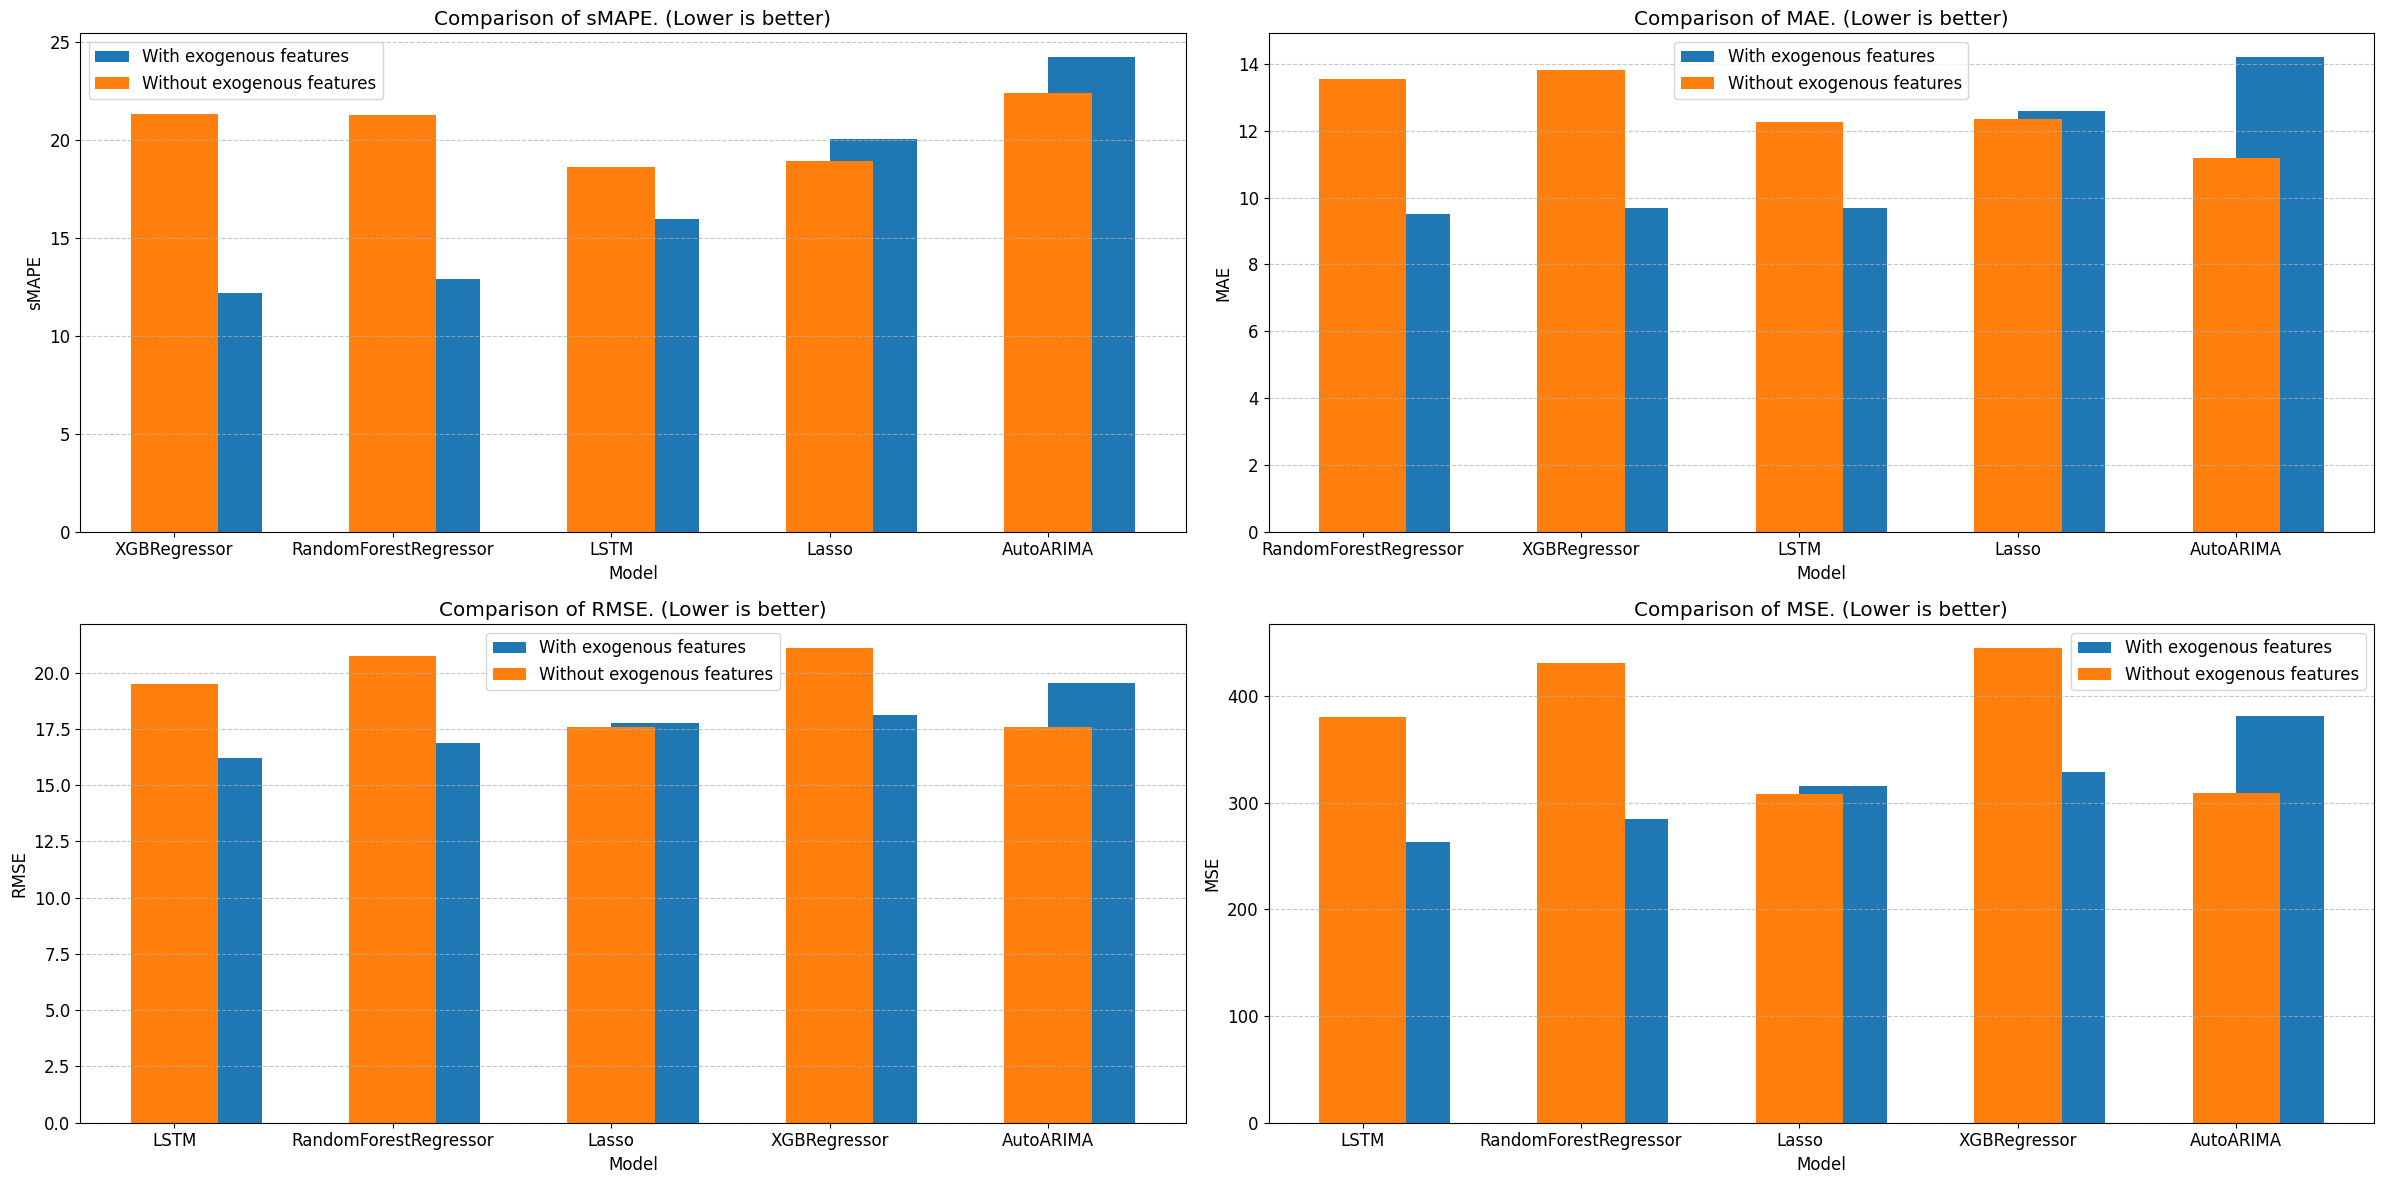

In [35]:
import pandas as pd
import matplotlib.pyplot as plt


# Set up the plotting area with 2 rows and 3 columns
fig, axes = plt.subplots(2, 2, figsize=(24, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# List of metrics to plot
metrics = ['sMAPE', 'MAE', 'RMSE', 'MSE']

# Plot each metric for each model
for i, metric in enumerate(metrics):
    ax = axes[i]

    # Merge DataFrames on 'Model name'
    merged_df = pd.merge(smape_list_df[['Model Column', metric]], smape_list_without_exog_df[['Model Column', metric]], on='Model Column', suffixes=('_df1', '_df2'))
    # Sort by sMAPE desc
    merged_df = merged_df.sort_values(by=[f'{metric}_df1', 'Model Column'], ascending=[True, True])

    # Plot bar chart
    ax.bar(merged_df['Model Column'], merged_df[f'{metric}_df1'], width=0.4, label='With exogenous features', align='edge')
    ax.bar(merged_df['Model Column'], merged_df[f'{metric}_df2'], width=0.4, label='Without exogenous features', align='center')
    # Include gridline
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Set titles and labels
    ax.set_title(f'Comparison of {metric}. (Lower is better)')
    ax.set_xlabel('Model')
    ax.set_ylabel(metric)
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()